Author:    DIVYAM

    First Year student in B.Tech. CSE at IIT Guwahati

OBJECTIVE:

    Predicting occupation of people there using their dietary habits, wealth indices, housing details, transit methods etc.
    Helping recover Atlantis historical occupation logs.

PROBLEM TYPE: 
   
    Multi Class Classification Problem

IMPORT AND ENVIRONMENT SETUP

In [1]:
import pandas as pd              # For loading and cleaning of the tabular data.
import numpy as np               # For high-performance math and array operations.
import matplotlib.pyplot as plt  # For creating plots and figures.
import seaborn as sns            # For data visualization.
import re                        # For searching within string, modifying it etc.

from sklearn.model_selection import GridSearchCV                 # For hyperparameter tuning and cross validation.
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # For encoding categories and scaling numbers.
from sklearn.compose import ColumnTransformer                    # For applying transformations to different columns.
from sklearn.pipeline import Pipeline                            # For sequencing preprocessing and modeling to prevent data leakage.
from catboost import CatBoostClassifier, Pool                    # For model training.

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix     # For predicting various evaluation metrics.

pd.set_option('display.max_columns', None)  # for showing all columns in DataFrames.
sns.set_style('whitegrid')                  # Setting a clean visual theme for plots.



DATA LOADING 
        
        Taking care to separately handle training and test datasets, to prevent influence of test datasets on our model.



In [2]:
train = pd.read_csv("atlantis_citizens_final.csv")
test = pd.read_csv("test_atlantis_hidden.csv")
train_raw = train.copy()                              # for using original form of train if needed somewhere afterward.

DESCRIPTION

        Just taking an overall idea of the train and test dataframes.

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3938 entries, 0 to 3937
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Citizen_ID        3938 non-null   object
 1   Diet_Type         3938 non-null   object
 2   District_Name     3938 non-null   object
 3   Wealth_Index      3938 non-null   int64 
 4   House_Size_sq_ft  3938 non-null   int64 
 5   Life_Expectancy   3938 non-null   int64 
 6   Vehicle_Owned     3938 non-null   object
 7   Work_District     3938 non-null   object
 8   Bio_Hash          3938 non-null   object
dtypes: int64(3), object(6)
memory usage: 277.0+ KB


In [4]:

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Citizen_ID        15751 non-null  object 
 1   Diet_Type         15751 non-null  object 
 2   District_Name     15751 non-null  object 
 3   Occupation        15751 non-null  object 
 4   Wealth_Index      14696 non-null  float64
 5   House_Size_sq_ft  14554 non-null  float64
 6   Life_Expectancy   15137 non-null  float64
 7   Vehicle_Owned     15751 non-null  object 
 8   Work_District     15751 non-null  object 
 9   Bio_Hash          15751 non-null  object 
dtypes: float64(3), object(7)
memory usage: 1.2+ MB


Observe the training dataset just to see what datatypes are present (numerical and categorial), are there missing values and are there inconsistent values/formats also present etc.

ANALYSING:

    Analysing different columns of train dataset

In [5]:
for col in train.columns:
    print(f"--- Column: {col} ---")
    if train[col].dtype == 'object' or train[col].dtype.name == 'category':
        # For Categorical columns: Show number of types and the actual unique names
        print(f"Type: Categorical")
        print(f"Number of unique entries: {train[col].nunique()}")
        print(f"Top 5 categories: {train[col].value_counts().head(5).index.tolist()}")
    else:
        # For Numerical columns: Show Min, Max, Median
        print(f"Type: Numerical")
        print(f"Min: {train[col].min()}")
        print(f"Max: {train[col].max()}")
        print(f"Median: {train[col].median()}")
    print("\n")

--- Column: Citizen_ID ---
Type: Categorical
Number of unique entries: 15751
Top 5 categories: ['CIT_15935', 'CIT_15224', 'CIT_5253', 'CIT_13561', 'CIT_8341']


--- Column: Diet_Type ---
Type: Categorical
Number of unique entries: 3
Top 5 categories: ['Seafood', 'Seaweed', 'Exotic Imports']


--- Column: District_Name ---
Type: Categorical
Number of unique entries: 4
Top 5 categories: ['The Golden Reef', 'Deep Trench', 'Coral Slums', 'Mariana Plaza']


--- Column: Occupation ---
Type: Categorical
Number of unique entries: 5
Top 5 categories: ['Merchant', 'Warrior', 'Fisher', 'Miner', 'Scribe']


--- Column: Wealth_Index ---
Type: Numerical
Min: 1000.0
Max: 589377.0
Median: 3794.5


--- Column: House_Size_sq_ft ---
Type: Numerical
Min: 100.0
Max: 10000.0
Median: 477.0


--- Column: Life_Expectancy ---
Type: Numerical
Min: 20.0
Max: 110.0
Median: 49.0


--- Column: Vehicle_Owned ---
Type: Categorical
Number of unique entries: 5
Top 5 categories: ['Sea Scooter', 'No Vehicle', 'Fin Bicycle

**EXPLORATORY DATA ANALYSIS (EDA)**

    Drawing various plots/graph to identify patterns in the train dataset.


**(1)** 

    DISTRIBUTION OF Log(WEALTH) ACROSS DIFFERENT OCCUPATIONS

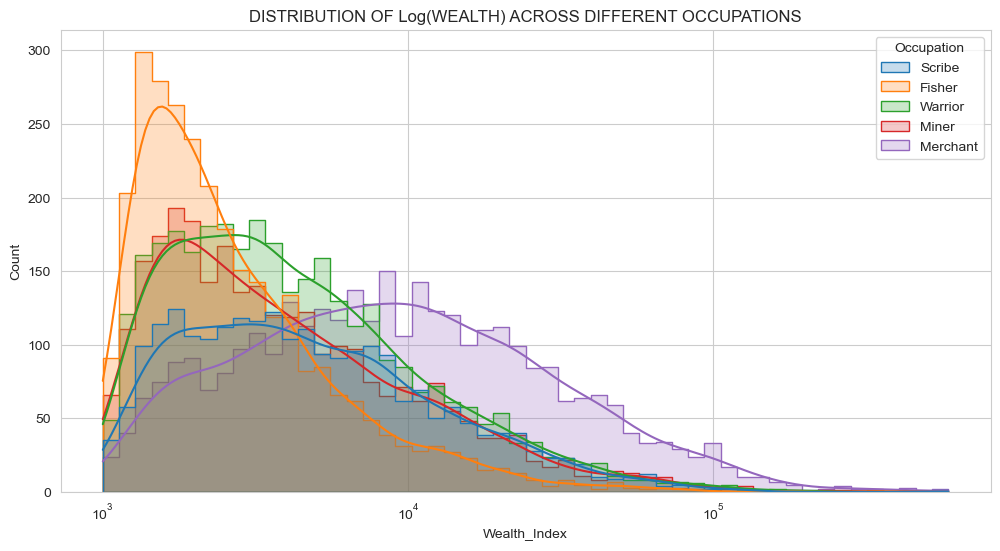

In [6]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='Wealth_Index', hue='Occupation', log_scale=True, kde=True, element="step")
plt.title('DISTRIBUTION OF Log(WEALTH) ACROSS DIFFERENT OCCUPATIONS')
plt.show()

OBSERVATION: 

    For occupations like Scribe, Fisher, Warrior and Miner, wealth is heavily skewed toward the lower side and for Merchant, log(wealth) has more or less normal distribution.

**(2)** 

    DISTRIBUTION OF Log(HOUSE SIZE) ACROSS VARIOUS OCCUPATIONS

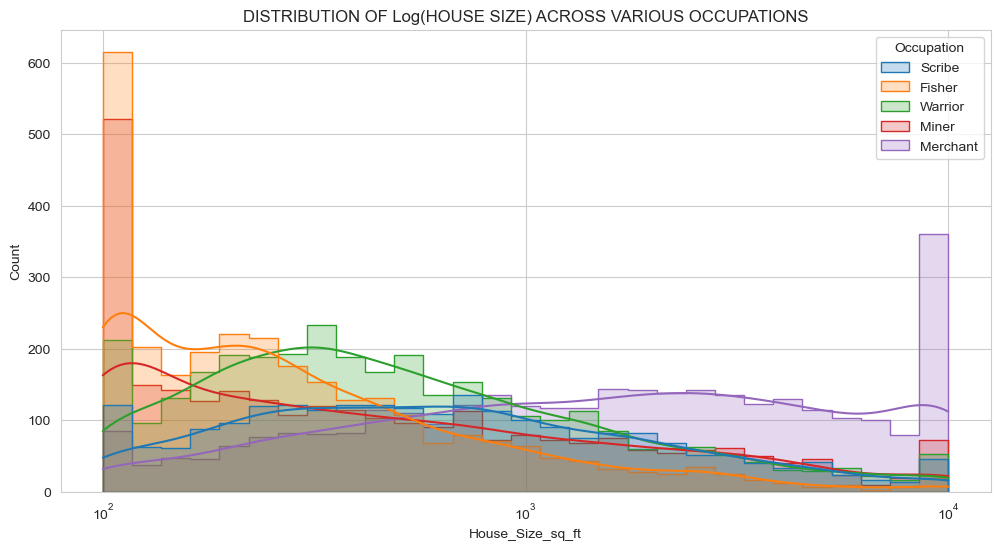

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='House_Size_sq_ft', hue='Occupation', log_scale=True, kde=True, element="step")
plt.title('DISTRIBUTION OF Log(HOUSE SIZE) ACROSS VARIOUS OCCUPATIONS')
plt.show()

OBSERVATION:

    For Fisher and Miner House size are generally small, Warrior generally have house sizes in middle range whereas Merchant occupation has bigger house sizes than rest of the occupations on average.

**(3)**

    DISTRIBUTION OF LIFE EXPECTANCY ACROSS VARIOUS OCCUPATIONS

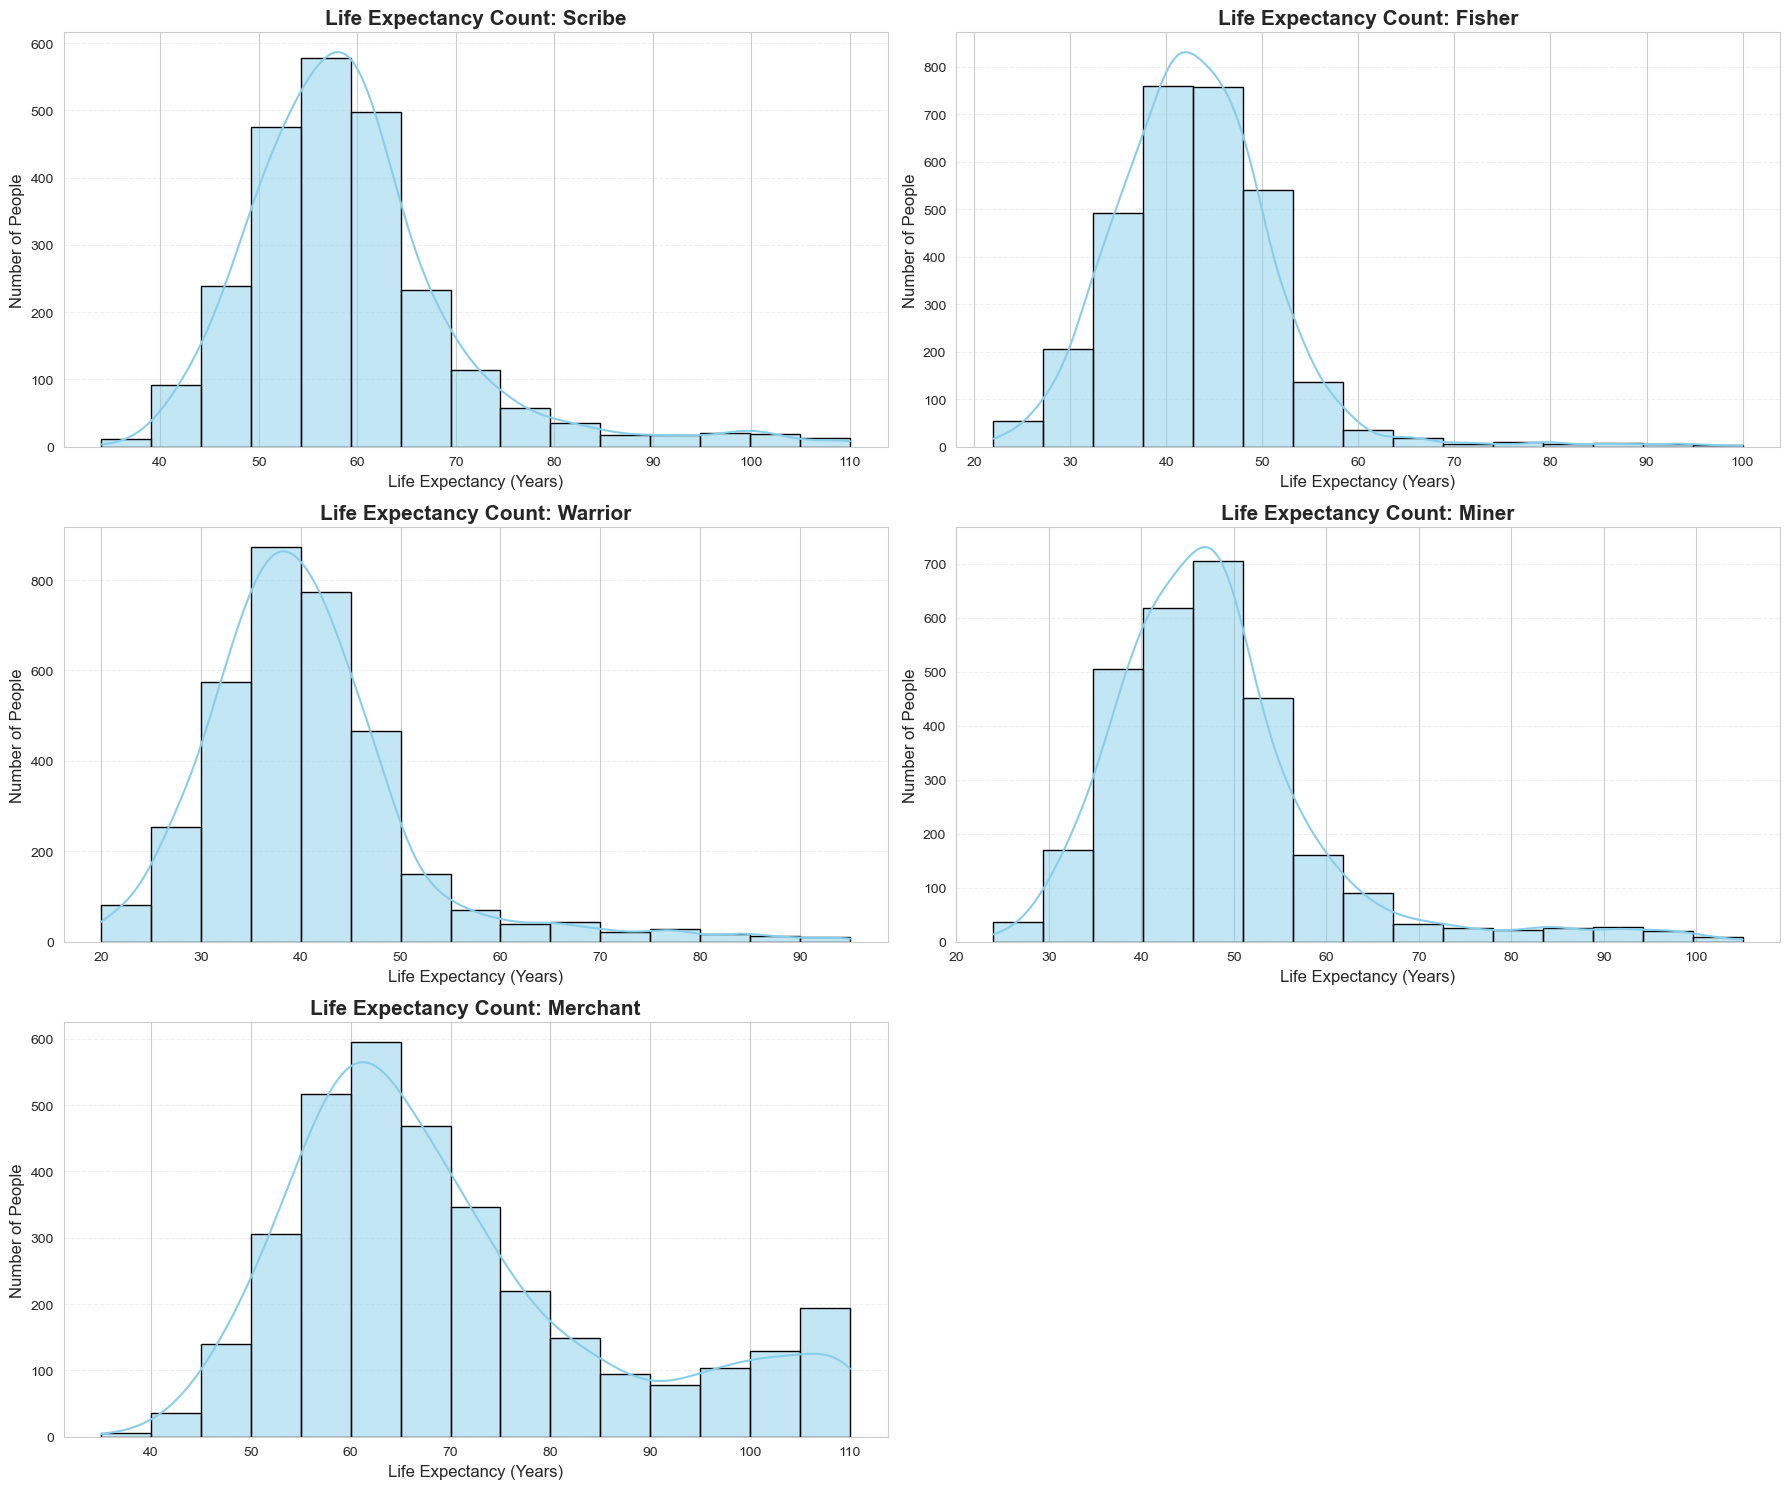

In [8]:

import math

# Preparing data
occupations = train['Occupation'].unique()
num_plots = len(occupations)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

plt.figure(figsize=(18, 5 * num_rows))

for i, occ in enumerate(occupations, 1):
    plt.subplot(num_rows, num_cols, i)
    
    # Filter for the specific occupation
    subset = train[train['Occupation'] == occ]
    
    # Creating bin-like plot
    sns.histplot(
        data=subset, 
        x='Life_Expectancy', 
        bins=15,         
        kde=True,         
        color='skyblue', 
        edgecolor='black'
    )
    
    plt.title(f'Life Expectancy Count: {occ}', fontsize=15, fontweight='bold')
    plt.xlabel('Life Expectancy (Years)', fontsize=12)
    plt.ylabel('Number of People', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

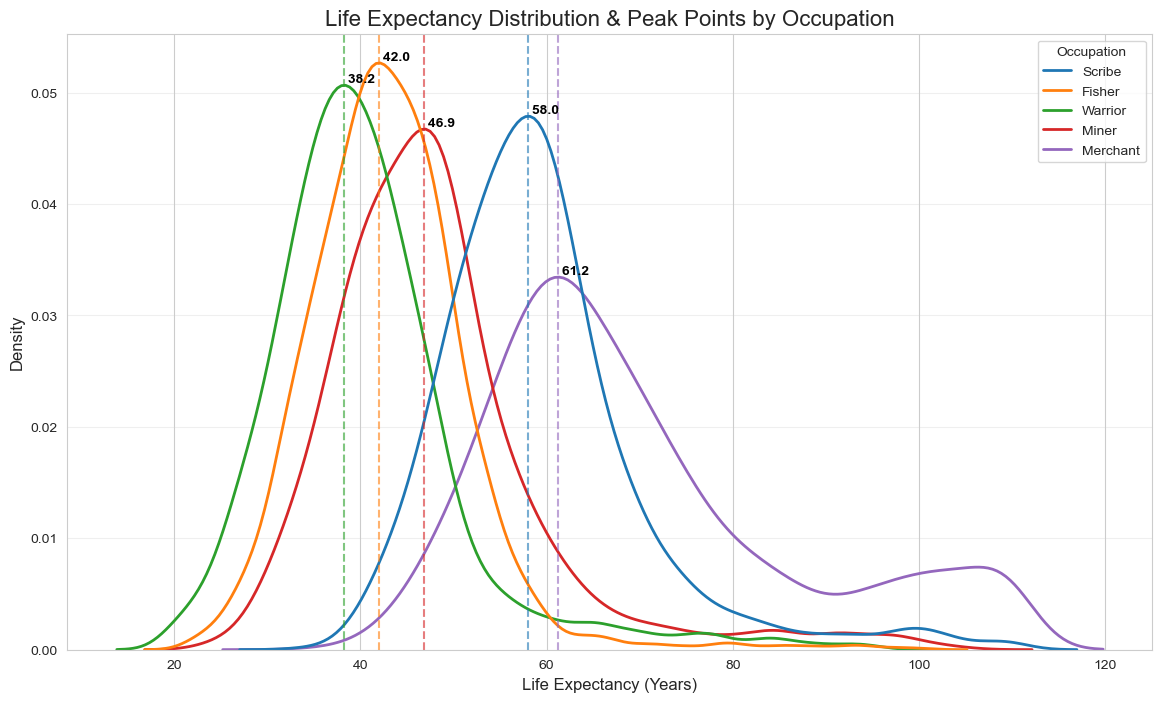

In [9]:

from scipy.stats import gaussian_kde

plt.figure(figsize=(14, 8))

# Creating the KDE Plot (gives idea of probability instead of direct count)
kde_plot = sns.kdeplot(
    data=train,
    x='Life_Expectancy',
    hue='Occupation',
    common_norm=False,
    linewidth=2
)

# Marking the Peaks
occupations = train['Occupation'].unique()
colors = sns.color_palette("tab10", len(occupations))

for i, occ in enumerate(occupations):
    # taking data for this occupation and dropping NaNs
    subset = train[train['Occupation'] == occ]['Life_Expectancy'].dropna()
    
    if len(subset) > 0:
        # Calculate KDE to find the peak mathematically
        kde = gaussian_kde(subset)
        x_range = np.linspace(subset.min(), subset.max(), 1000)
        y_values = kde(x_range)
        
        peak_x = x_range[np.argmax(y_values)] # The Life Expectancy at the peak
        peak_y = np.max(y_values)             # The Density at the peak
        
        plt.axvline(peak_x, color=colors[i], linestyle='--', alpha=0.6)
        
        # Adding label
        plt.text(peak_x, peak_y, f' {peak_x:.1f}', 
                 color='black', fontweight='bold', fontsize=10,
                 verticalalignment='bottom')

plt.title('Life Expectancy Distribution & Peak Points by Occupation', fontsize=16)
plt.xlabel('Life Expectancy (Years)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

OBSERVATION: 

    There is high probability that Warrior occupation has lower life expectancy which is around 38, and similarly 42 for Fisher and 47 for Miner. Scribe and Merchant have more probabilty for higher life expectancy.

**(4)** 

    LIFE EXPECTANCY v/s Log(HOUSE SIZE), HUE = OCCUPATIONS

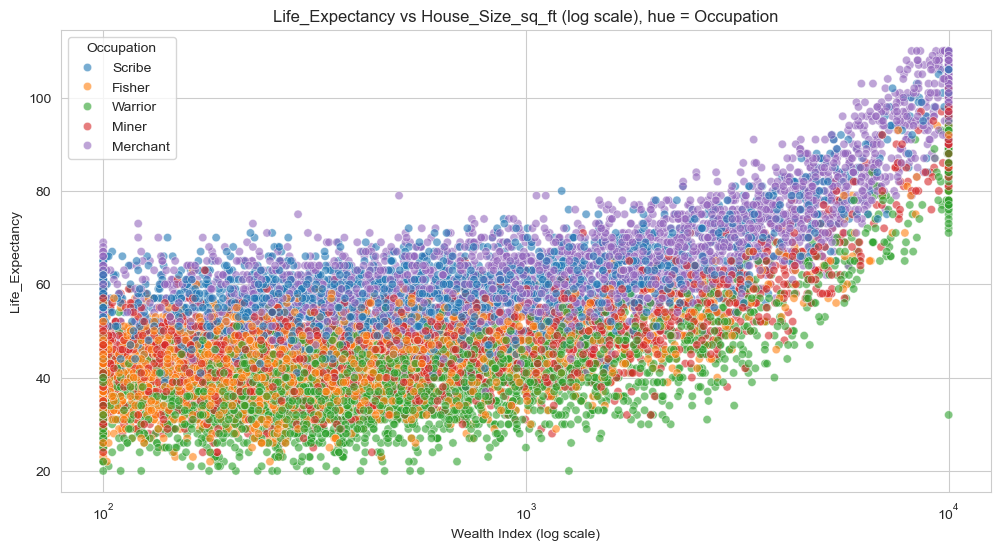

In [10]:


plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=train,
    x='House_Size_sq_ft',
    y='Life_Expectancy',
    hue='Occupation',
    alpha=0.6
)

plt.xscale('log')
plt.title('Life_Expectancy vs House_Size_sq_ft (log scale), hue = Occupation')
plt.xlabel('Wealth Index (log scale)')
plt.ylabel('Life_Expectancy')
plt.legend(title='Occupation')
plt.show()


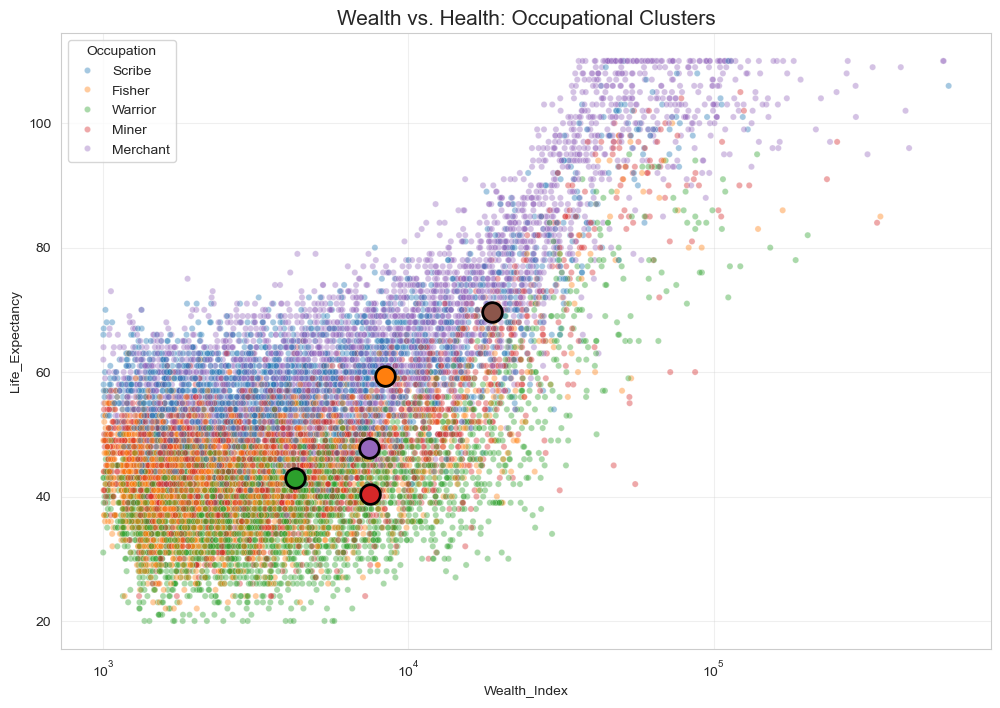

In [11]:

plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='Wealth_Index', y='Life_Expectancy', 
                hue='Occupation', alpha=0.4, s=20)

# Adding Centroids, The average point for each job
for occ in train['Occupation'].unique():
    subset = train[train['Occupation'] == occ]
    plt.scatter(subset['Wealth_Index'].mean(), subset['Life_Expectancy'].mean(), 
                s=200, edgecolors='black', linewidth=2, label=f'Avg {occ}')

plt.xscale('log')
plt.title('Wealth vs. Health: Occupational Clusters', fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

OBSERVATION:

    We can see that on increasing Wealth, life expectancy increases on average, almost holds for all occupations.

**(5)**

    DISTRIBUTION OF DIET_TYPES ACROSS VARIOUS OCCUPATIONS

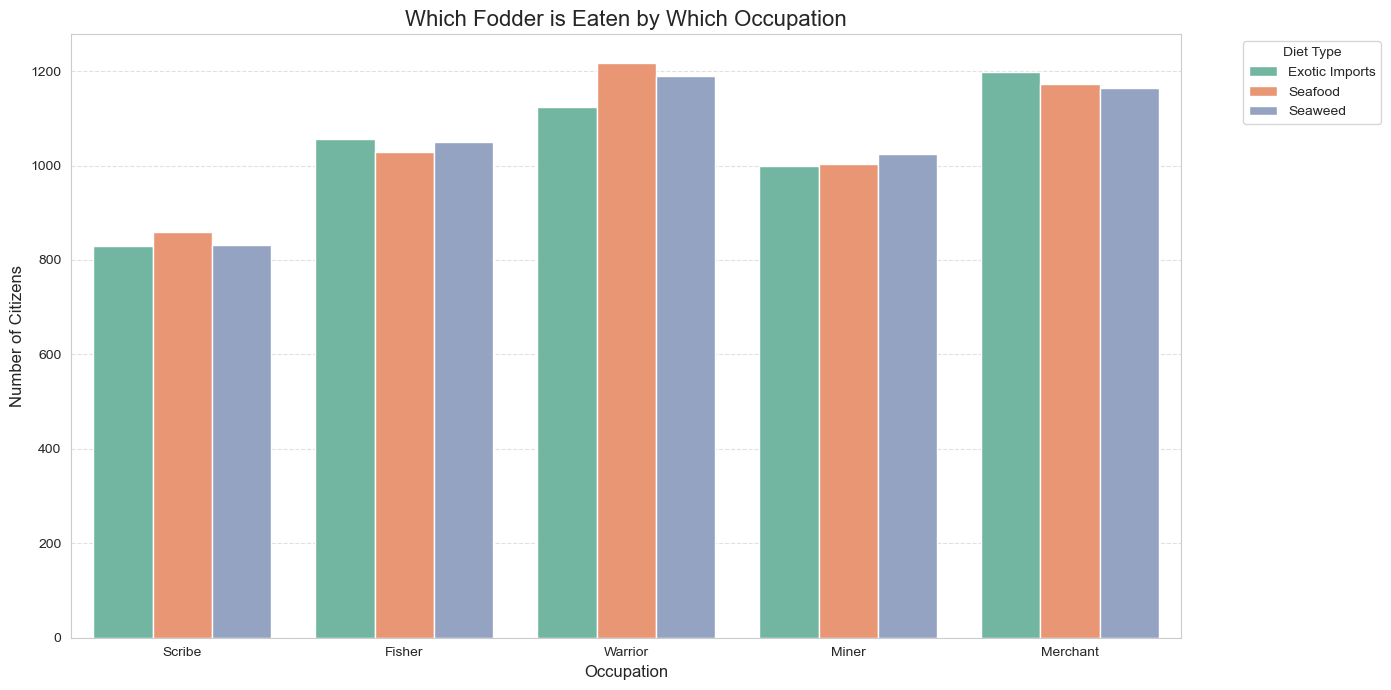

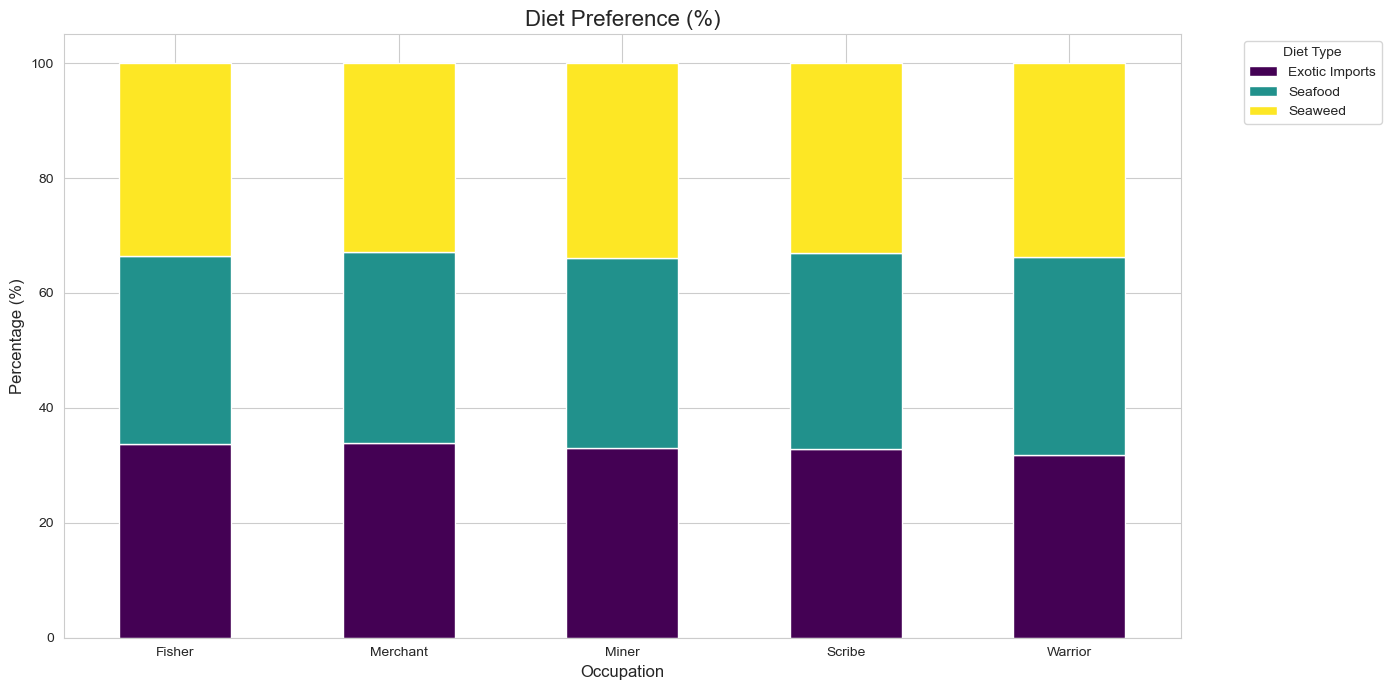

--- Diet Type Distribution by Occupation (%) ---
Diet_Type   Exotic Imports  Seafood  Seaweed
Occupation                                  
Fisher               33.71    32.81    33.48
Merchant             33.89    33.15    32.96
Miner                32.99    33.16    33.85
Scribe               32.92    34.11    32.96
Warrior              31.86    34.47    33.67


In [12]:

# Grouped Bar Chart
plt.figure(figsize=(14, 7))
sns.countplot(data=train, x='Occupation', hue='Diet_Type', palette='Set2')

plt.title('Which Fodder is Eaten by Which Occupation', fontsize=16)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Number of Citizens', fontsize=12)
plt.legend(title='Diet Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Normalized Stacked Bar Chart, shows percentages
diet_pct = pd.crosstab(train['Occupation'], train['Diet_Type'], normalize='index') * 100

diet_pct.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis', edgecolor='white')

plt.title('Diet Preference (%)', fontsize=16)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Diet Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("--- Diet Type Distribution by Occupation (%) ---")
print(diet_pct.round(2))

OBSERVATION: 

    For each occupation percentages of people eating Exotic Imports, Seafood, Seaweed are almost same.

**(6)** 

    DISTRIBUTION OF PEOPLE ACROSS WORK_DISTRCITS, HUE = OCCUPATIONS

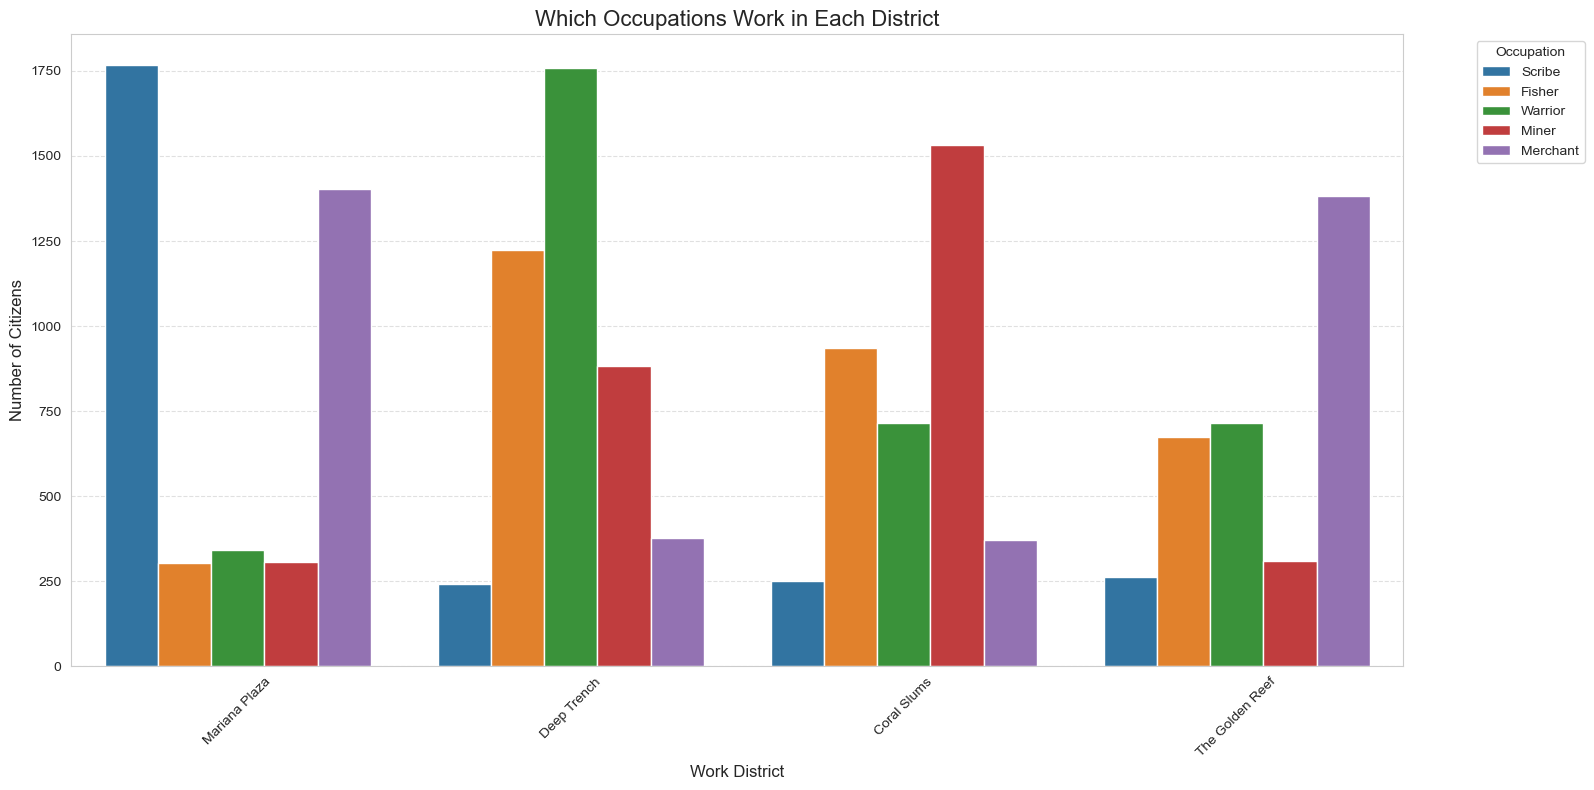

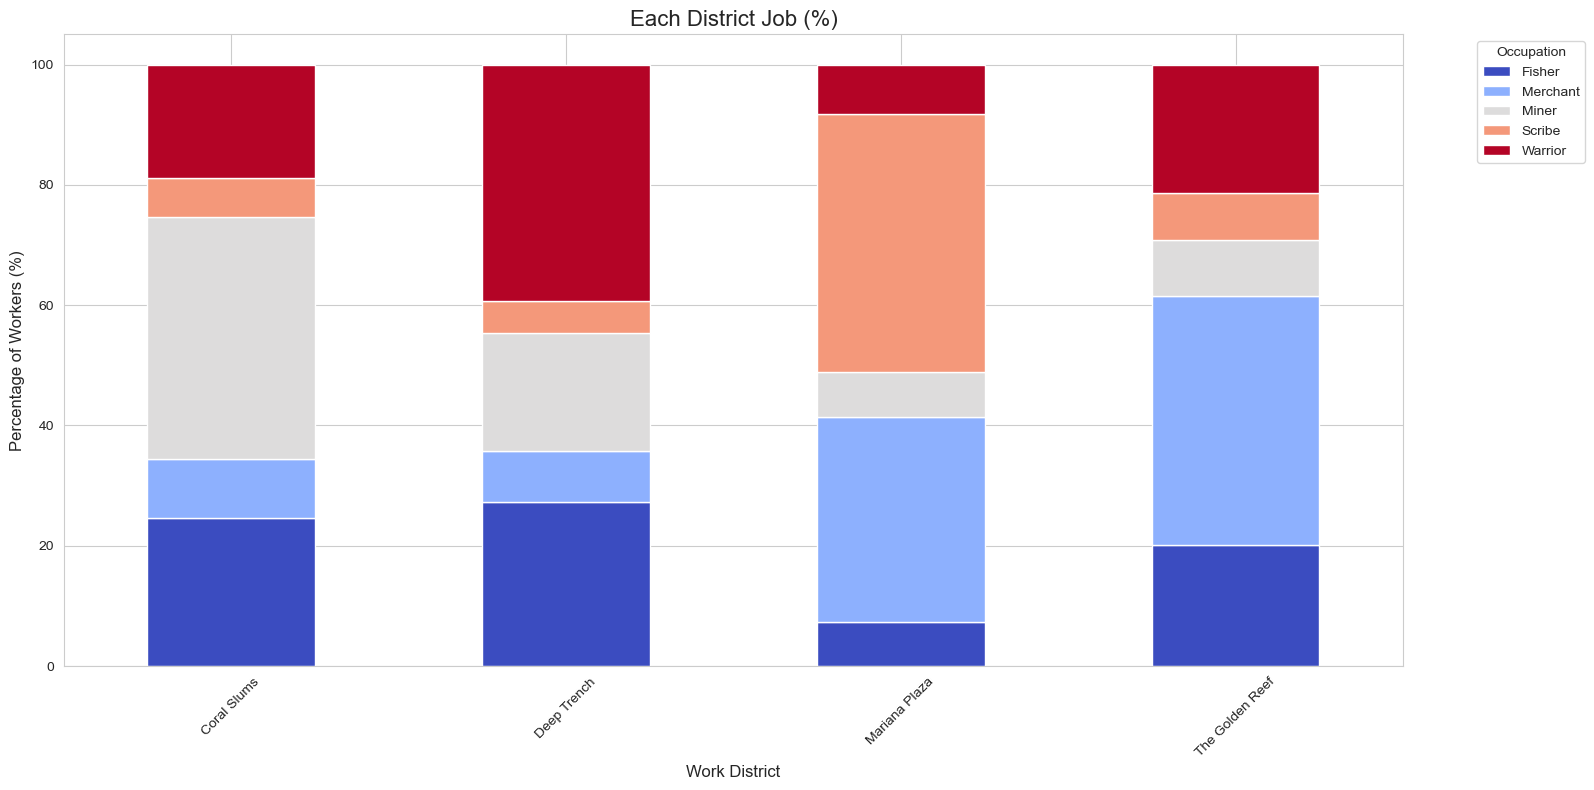

--- Occupation Distribution by Work District (%) ---
Occupation       Fisher  Merchant  Miner  Scribe  Warrior
Work_District                                            
Coral Slums       24.59      9.78  40.26    6.55    18.83
Deep Trench       27.30      8.43  19.67    5.35    39.24
Mariana Plaza      7.37     34.01   7.44   42.88     8.29
The Golden Reef   20.15     41.38   9.22    7.87    21.38


In [13]:

# Grouped Bar Chart
plt.figure(figsize=(16, 8))
sns.countplot(data=train, x='Work_District', hue='Occupation', palette='tab10')

plt.title('Which Occupations Work in Each District', fontsize=16)
plt.xlabel('Work District', fontsize=12)
plt.ylabel('Number of Citizens', fontsize=12)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Normalized Stacked Bar Chart
district_job_mix = pd.crosstab(train['Work_District'], train['Occupation'], normalize='index') * 100

district_job_mix.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='coolwarm', edgecolor='white')

plt.title('Each District Job (%)', fontsize=16)
plt.xlabel('Work District', fontsize=12)
plt.ylabel('Percentage of Workers (%)', fontsize=12)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Printing in tabular form
print("--- Occupation Distribution by Work District (%) ---")
print(district_job_mix.round(2))

OBSERVATION: 

    Merchants mainly work in Mariana Plaza and The Golden Reef, Warriors in Deep Trench, Scribes in Mariana Plaza and Miner in Coral Slums.

**(7)** 

    DISTRIBUTION OF PEOPLE ACROSS THE DISTRICTS, HUE = OCCUPATION

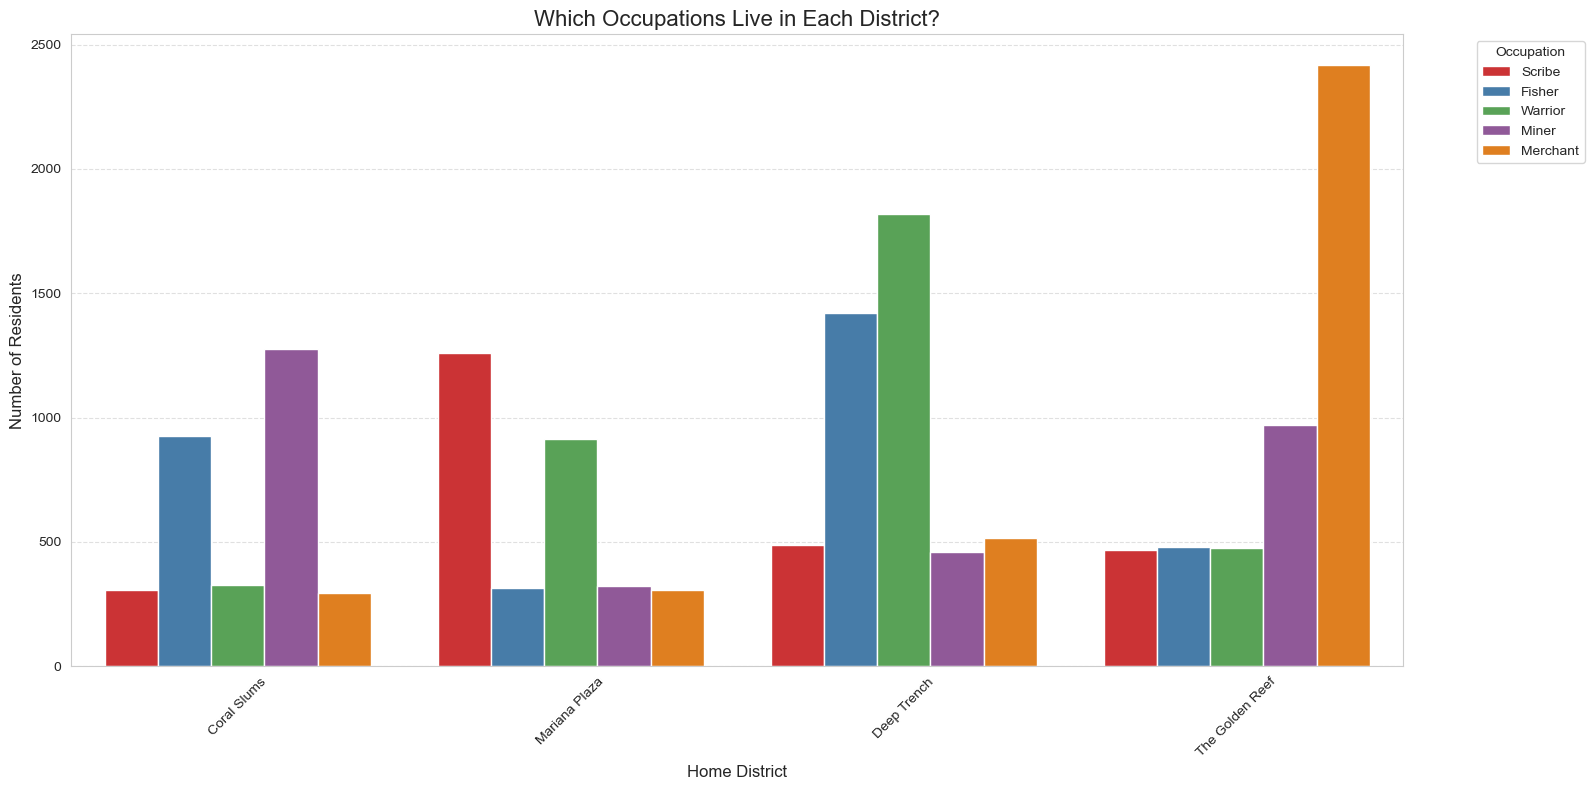

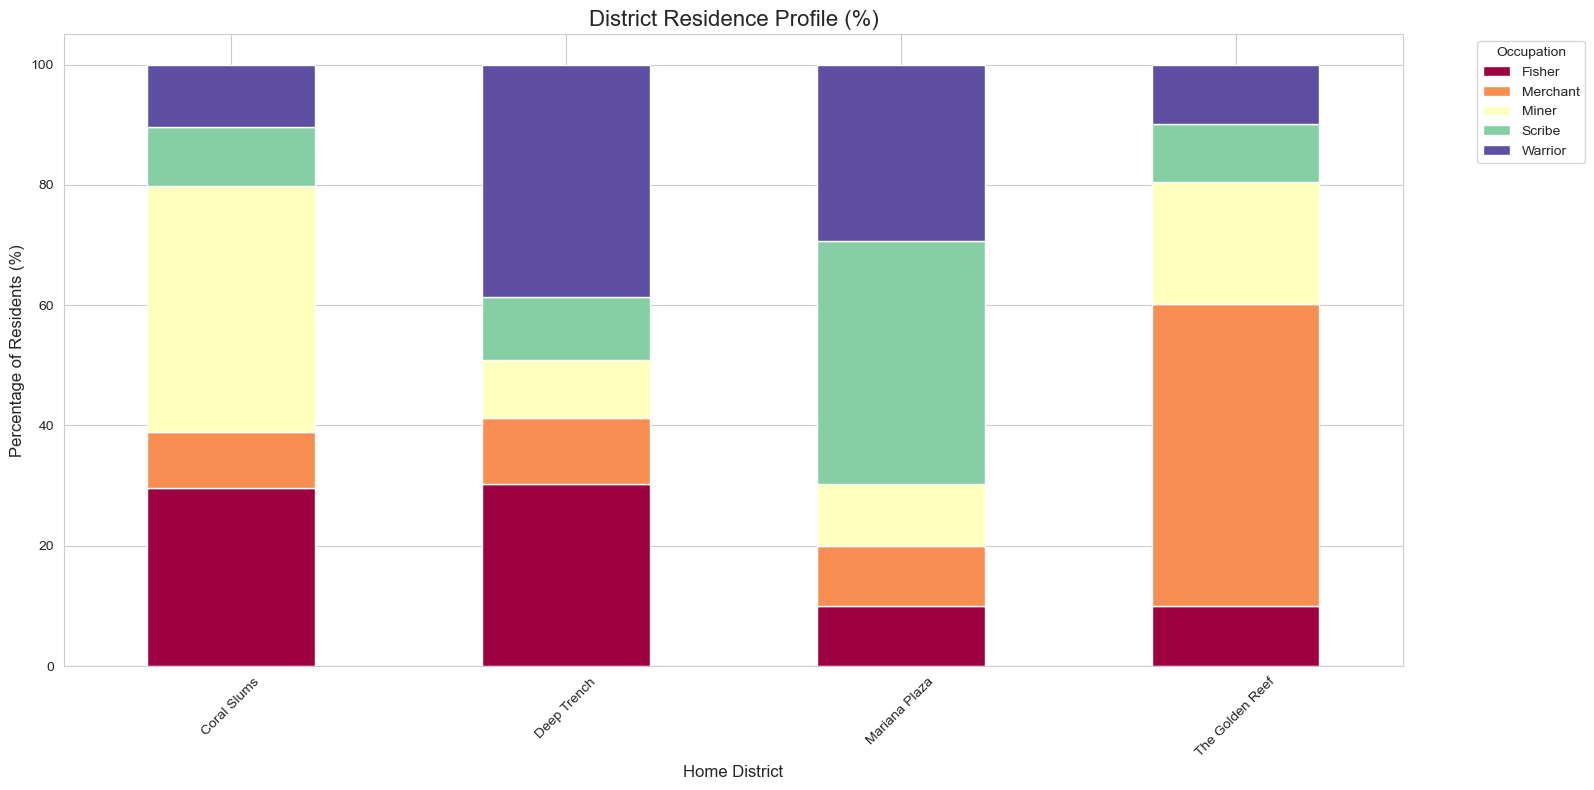

--- Occupation Distribution by Home District (%) ---
Occupation       Fisher  Merchant  Miner  Scribe  Warrior
District_Name                                            
Coral Slums       29.59      9.37  40.79    9.85    10.40
Deep Trench       30.22     10.99   9.75   10.35    38.69
Mariana Plaza     10.07      9.81  10.39   40.38    29.35
The Golden Reef    9.94     50.30  20.18    9.73     9.85


In [14]:


# Grouped Bar Chart
plt.figure(figsize=(16, 8))
sns.countplot(data=train, x='District_Name', hue='Occupation', palette='Set1')

plt.title('Which Occupations Live in Each District?', fontsize=16)
plt.xlabel('Home District', fontsize=12)
plt.ylabel('Number of Residents', fontsize=12)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Normalized Stacked Bar Chart
home_job_mix = pd.crosstab(train['District_Name'], train['Occupation'], normalize='index') * 100

home_job_mix.plot(kind='bar', stacked=True, figsize=(16, 8), colormap='Spectral', edgecolor='white')

plt.title('District Residence Profile (%)', fontsize=16)
plt.xlabel('Home District', fontsize=12)
plt.ylabel('Percentage of Residents (%)', fontsize=12)
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Numeric Table
print("--- Occupation Distribution by Home District (%) ---")
print(home_job_mix.round(2))

OBSERVATION: 

    More than 50% of the people based in The Golden Reef are Merchants and similarly most of the Miners are based in Coral Slums, Scribes in Mariana Plaza.


**(8)**

    DISTRIBUTION OF PEOPLE ACROSS OCCUPATIONS BY VEHICLE

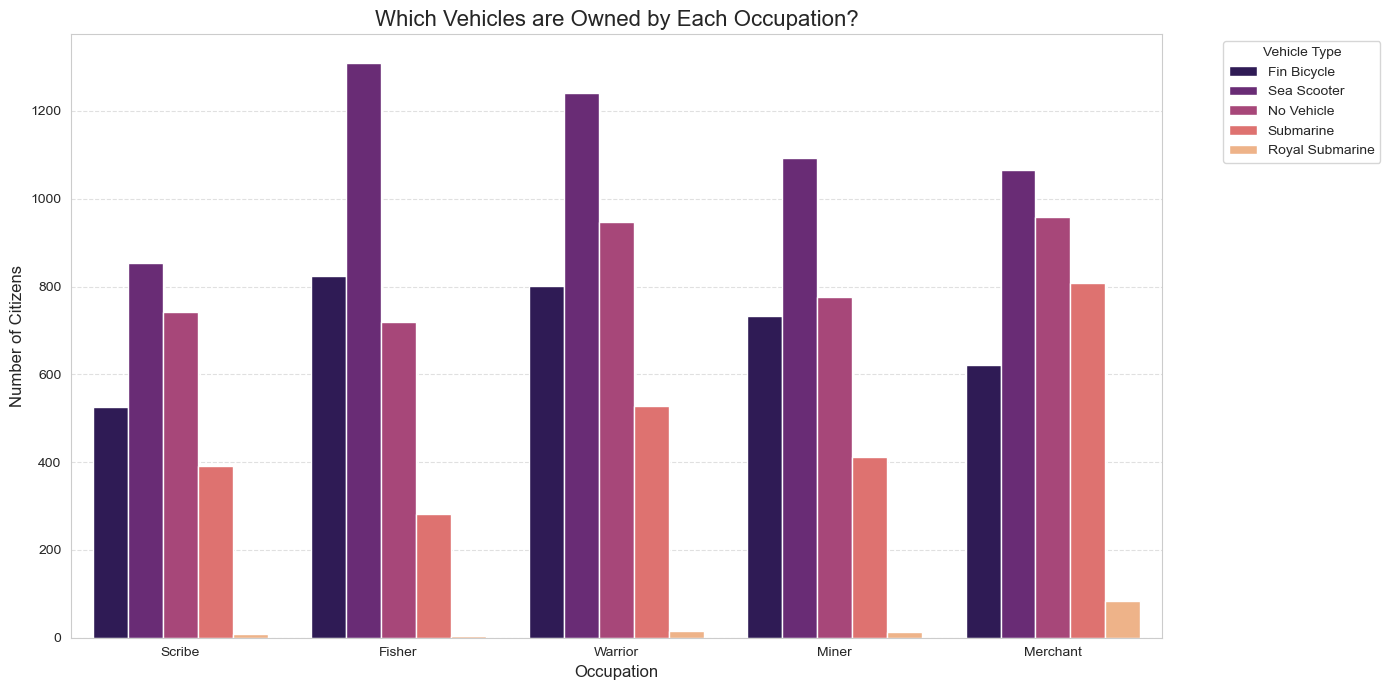

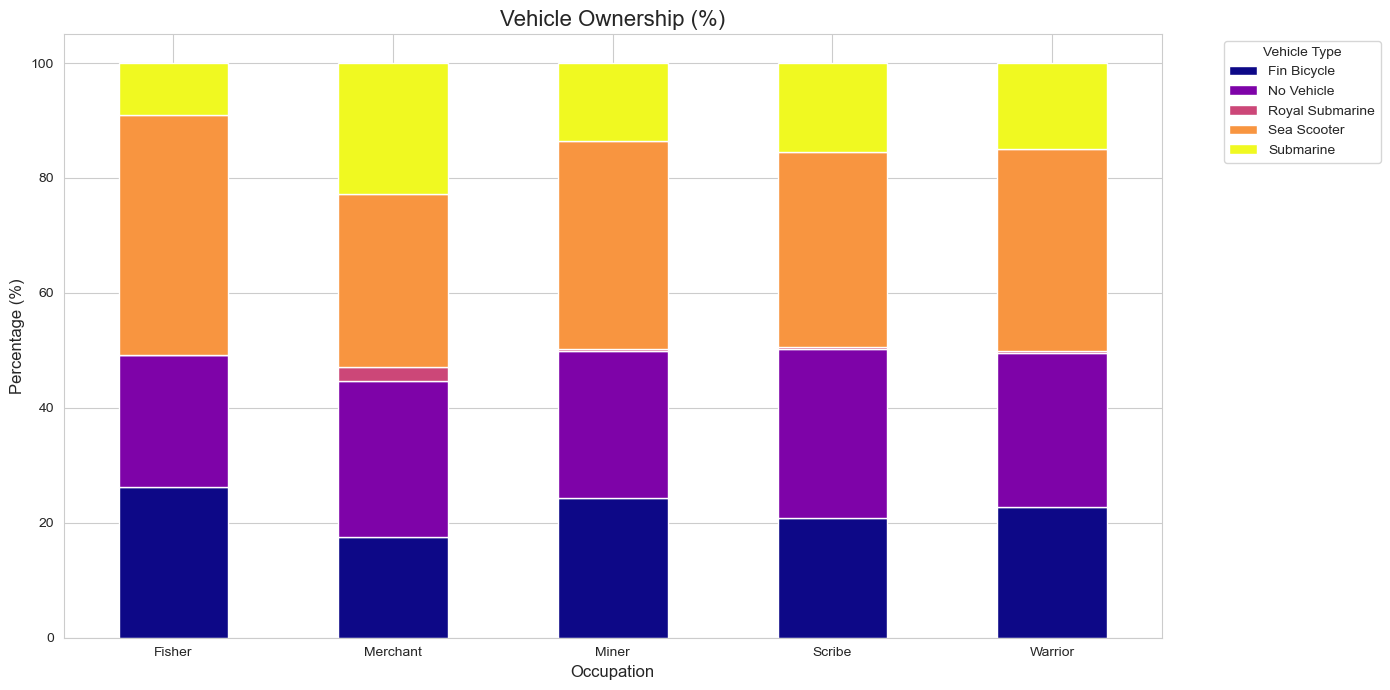

--- Vehicle Distribution by Occupation (%) ---
Vehicle_Owned  Fin Bicycle  No Vehicle  Royal Submarine  Sea Scooter  \
Occupation                                                             
Fisher               26.24       22.93             0.10        41.74   
Merchant             17.60       27.10             2.35        30.13   
Miner                24.24       25.66             0.40        36.10   
Scribe               20.86       29.43             0.32        33.84   
Warrior              22.68       26.82             0.40        35.15   

Vehicle_Owned  Submarine  
Occupation                
Fisher              8.99  
Merchant           22.83  
Miner              13.61  
Scribe             15.55  
Warrior            14.95  


In [15]:

# Grouped Bar Chart
plt.figure(figsize=(14, 7))
sns.countplot(data=train, x='Occupation', hue='Vehicle_Owned', palette='magma')

plt.title('Which Vehicles are Owned by Each Occupation?', fontsize=16)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Number of Citizens', fontsize=12)
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Normalized Stacked Bar Chart
vehicle_pct = pd.crosstab(train['Occupation'], train['Vehicle_Owned'], normalize='index') * 100

vehicle_pct.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='plasma', edgecolor='white')

plt.title('Vehicle Ownership (%)', fontsize=16)
plt.xlabel('Occupation', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Printing the numeric table
print("--- Vehicle Distribution by Occupation (%) ---")
print(vehicle_pct.round(2))

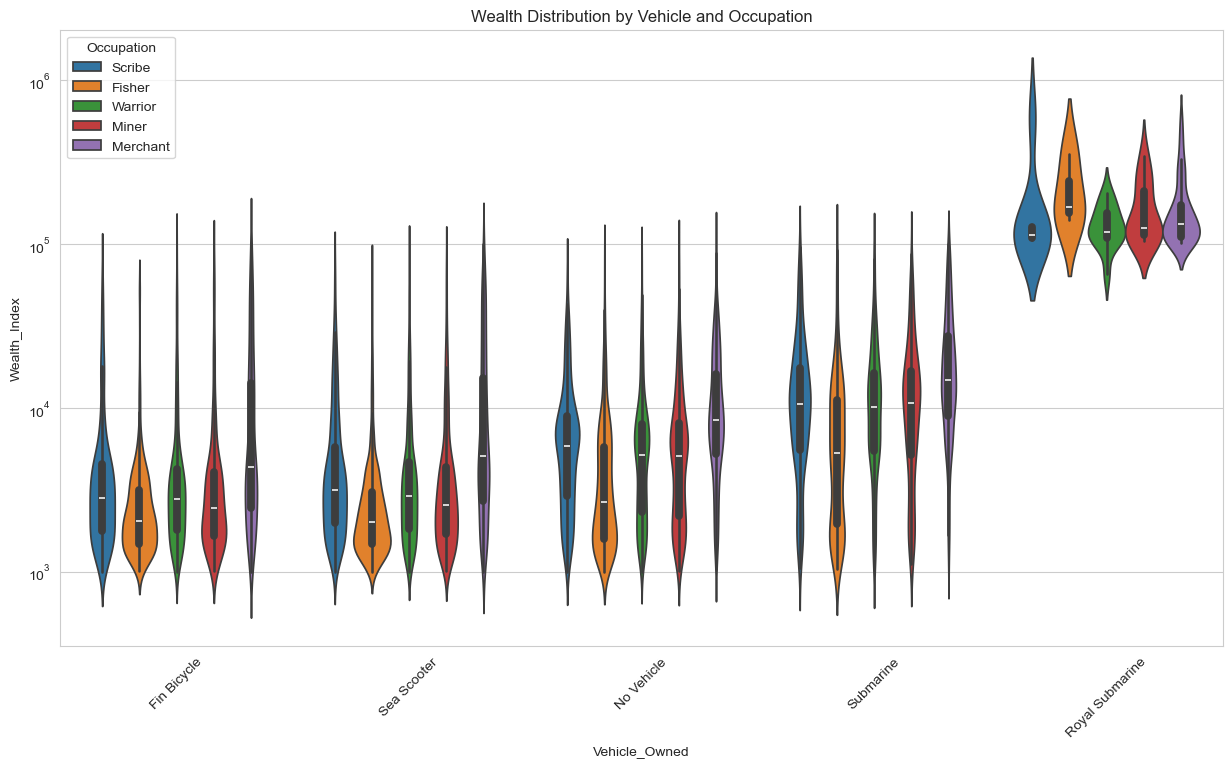

In [16]:
plt.figure(figsize=(15, 8))
plt.yscale('log')
sns.violinplot(data=train, x='Vehicle_Owned', y='Wealth_Index', hue='Occupation', split=False)
plt.xticks(rotation=45)
plt.title('Wealth Distribution by Vehicle and Occupation')
plt.show()

OBSERVATION: 

    In all occupations the most owned vehicle is Sea Scooter and The Royal Submarine is mainly limited to the Merchants.

**(9)**

    Log(HOUSE SIZE) v/s Log(WEALTH) OCCUPATION-WISE, HUE = DISTRICT_NAME

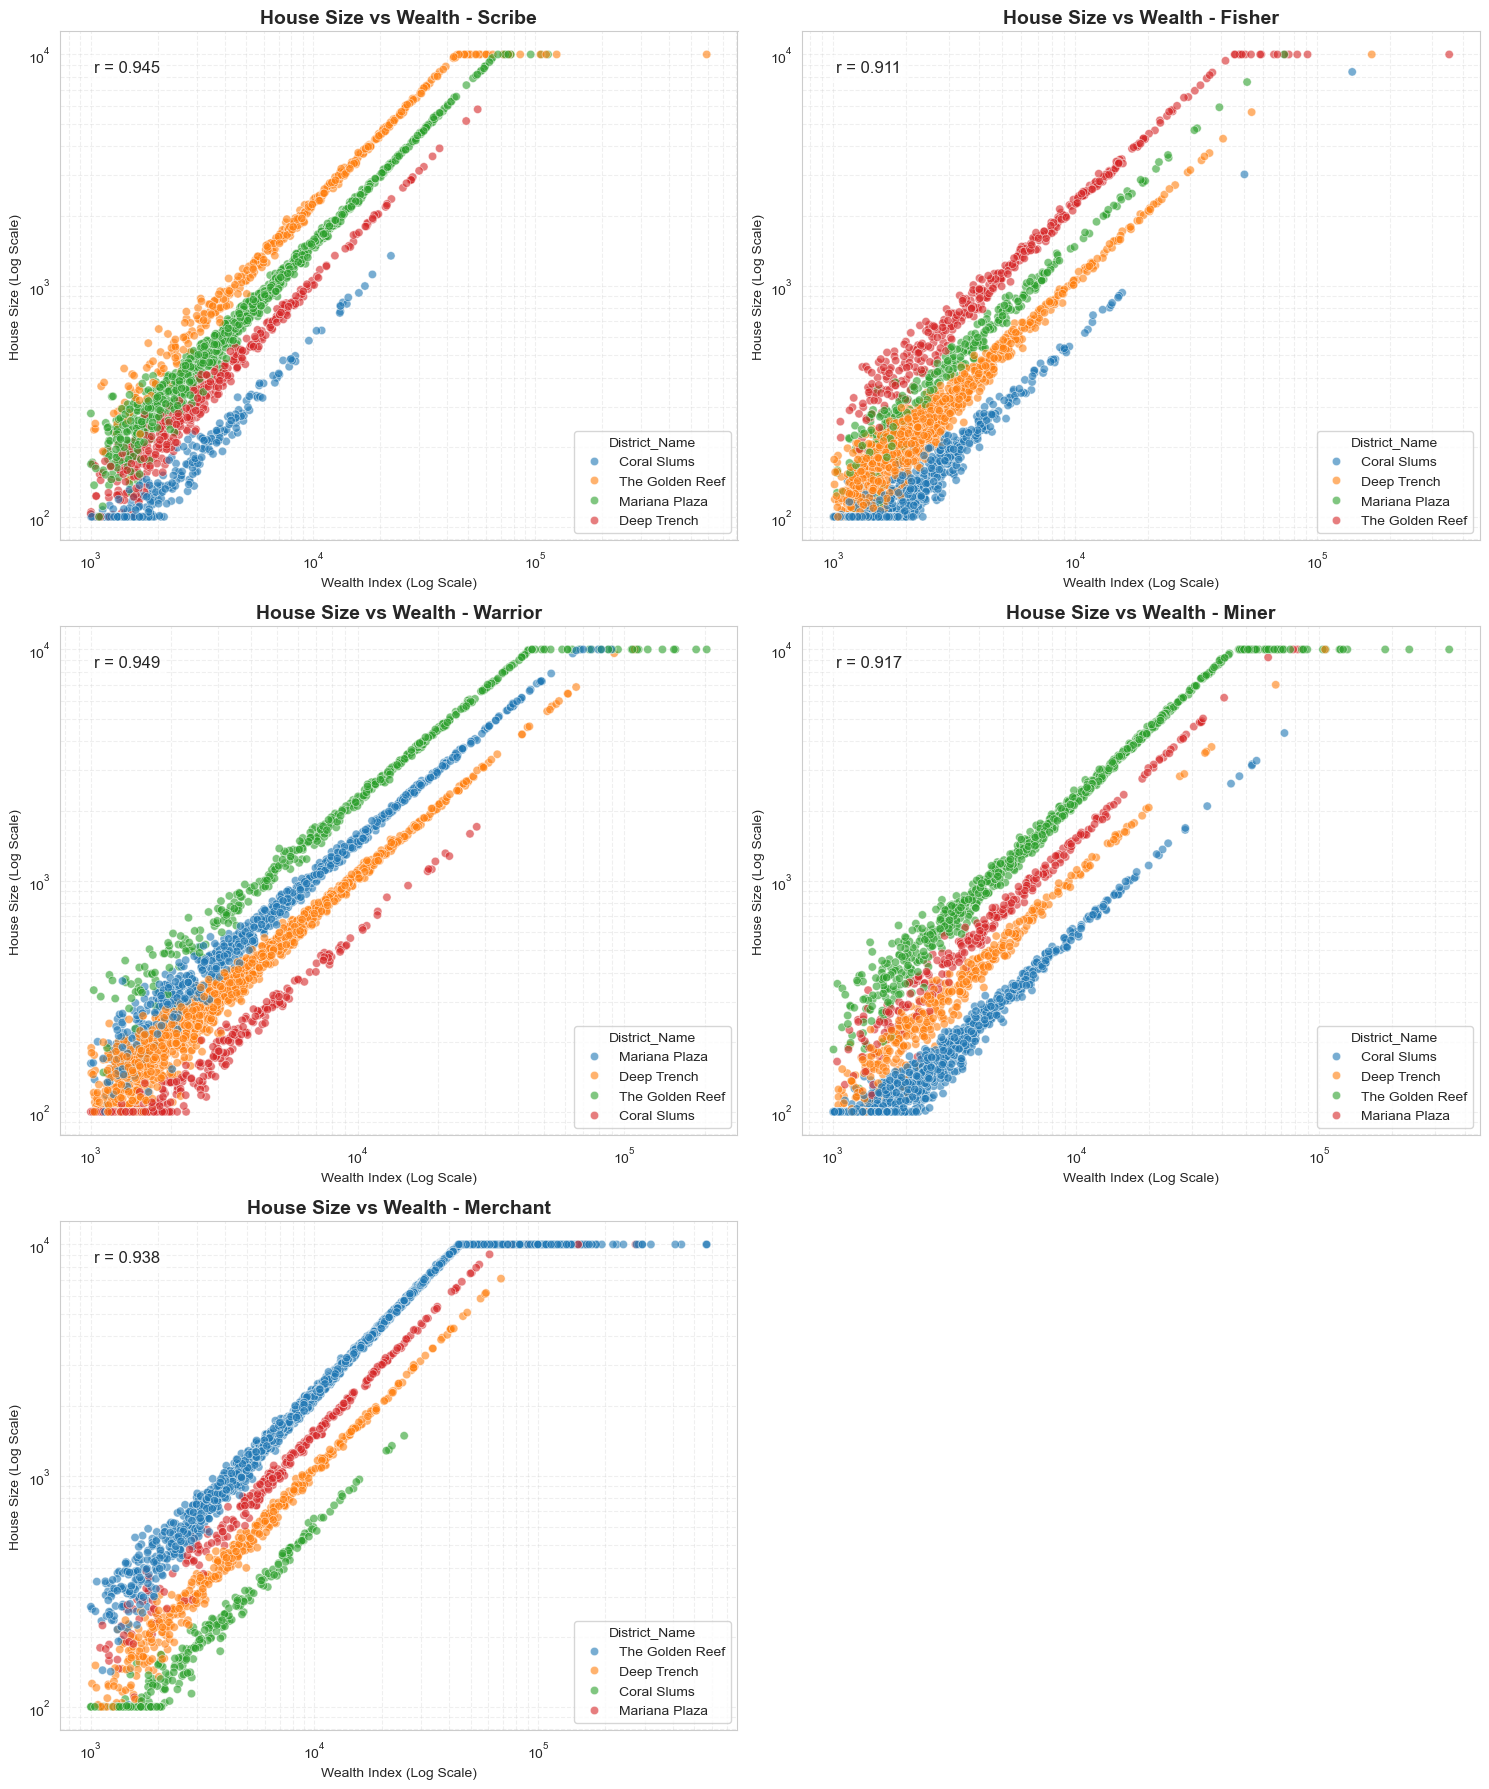

In [17]:

from scipy.stats import pearsonr
import math

occupations = train['Occupation'].unique()
num_plots = len(occupations)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols) # Automatically sets rows based on count

plt.figure(figsize=(15, 6 * num_rows))

for i, occ in enumerate(occupations, 1):
    plt.subplot(num_rows, num_cols, i)
    
    # Filtering non-positive values
    subset = train[(train['Occupation'] == occ) & 
                   (train['Wealth_Index'] > 0) & 
                   (train['House_Size_sq_ft'] > 0)].copy()
    
    if len(subset) > 1:
        # Correlation calculation
        log_wealth = np.log10(subset['Wealth_Index'])
        log_house = np.log10(subset['House_Size_sq_ft'])
        corr, _ = pearsonr(log_wealth, log_house)
        
        # Plotting
        sns.scatterplot(
            data=subset,
            x='Wealth_Index',
            y='House_Size_sq_ft',
            hue='District_Name',
            alpha=0.6,
            color='teal' 
        )
        
        # Log Scales
        plt.xscale('log')
        plt.yscale('log')
        
        plt.title(f'House Size vs Wealth - {occ}', fontsize=14, fontweight='bold')
        plt.xlabel('Wealth Index (Log Scale)')
        plt.ylabel('House Size (Log Scale)')
        
        # Annotate Correlation
        plt.text(0.05, 0.92, f'r = {corr:.3f}', 
                 transform=plt.gca().transAxes, 
                 fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.7))
        
        plt.grid(True, which="both", linestyle='--', alpha=0.3)
    else:
        plt.text(0.5, 0.5, f'Insufficient data for {occ}', ha='center')

plt.tight_layout()
plt.show()

OBSERVATION: 

    In each Log(house size) v/s Log(wealth) graph i.e. for each occupation the points are nealty divided into groups based on their district name.

**(10)**

    CALCULATING BEST FIT LINE FOR EACH CLUSTER OF POINTS FOR EACH OCCUPATION

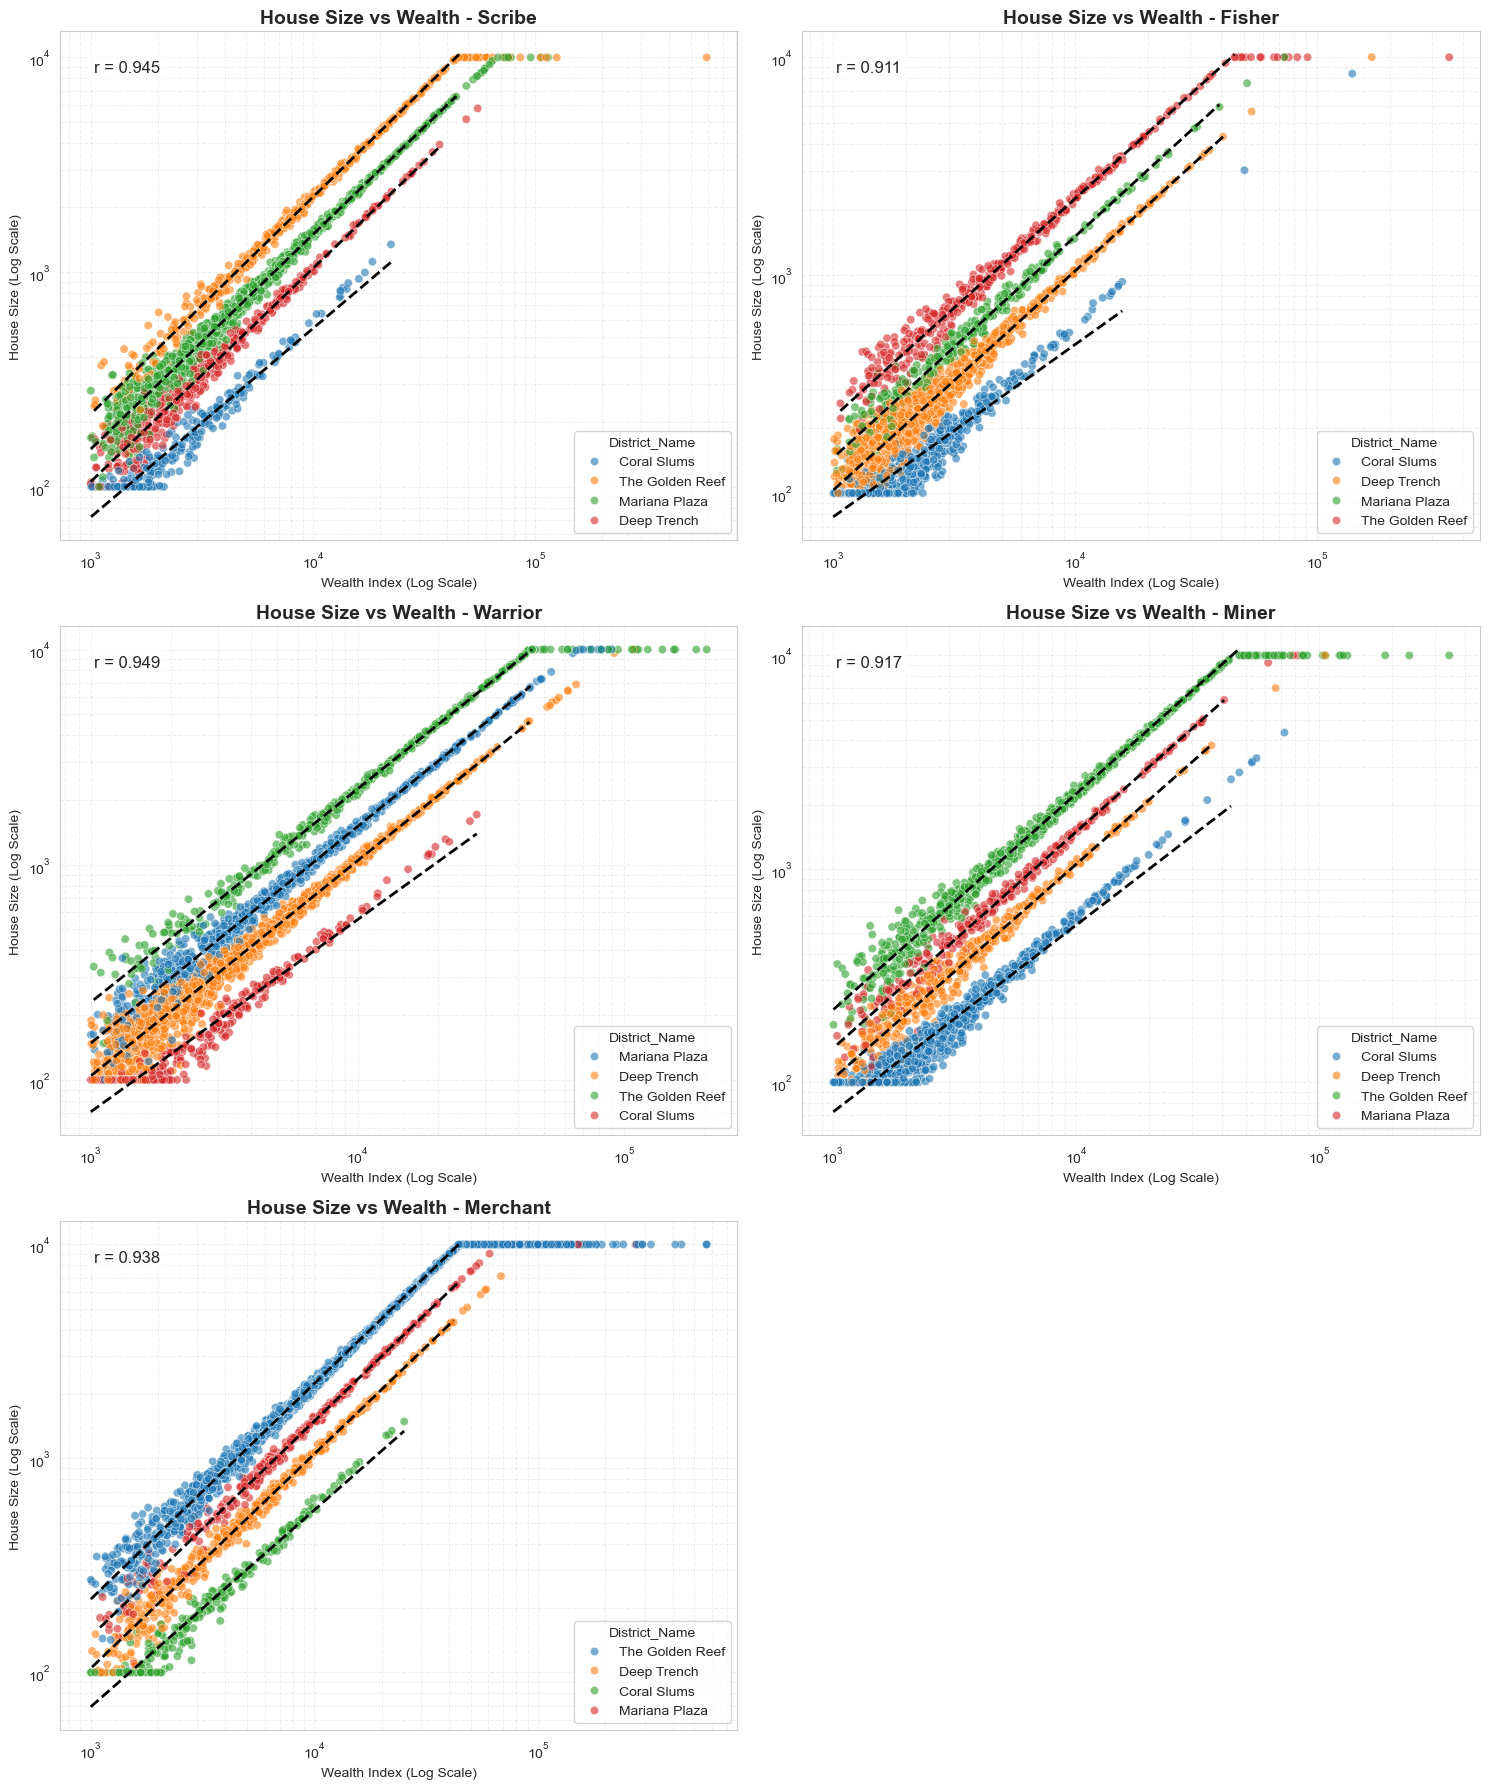

In [18]:

from scipy.stats import pearsonr
import math

wealth_cutoff = {
    'Fisher': 45647.0,
    'Merchant': 44168.0,
    'Miner': 46718.0,
    'Scribe': 45312.0,
    'Warrior': 45060.0
}
# above is the cutoff for highest house size in the train dataset which is 10000 sq ft


occupations = train['Occupation'].unique()
num_plots = len(occupations)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)

plt.figure(figsize=(15, 6 * num_rows))

equations = []

for i, occ in enumerate(occupations, 1):
    plt.subplot(num_rows, num_cols, i)

    subset_occ = train[
        (train['Occupation'] == occ) &
        (train['Wealth_Index'] > 0) &
        (train['House_Size_sq_ft'] > 0)
    ].copy()

    if len(subset_occ) <= 1:
        plt.text(0.5, 0.5, f'Insufficient data for {occ}', ha='center')
        continue

    # plot for all points
    sns.scatterplot(
        data=subset_occ,
        x='Wealth_Index',
        y='House_Size_sq_ft',
        hue='District_Name',
        alpha=0.6
    )

    plt.xscale('log')
    plt.yscale('log')

    # Overall correlation
    log_wealth = np.log10(subset_occ['Wealth_Index'])
    log_house = np.log10(subset_occ['House_Size_sq_ft'])
    corr, _ = pearsonr(log_wealth, log_house)

    plt.title(f'House Size vs Wealth - {occ}', fontsize=14, fontweight='bold')
    plt.xlabel('Wealth Index (Log Scale)')
    plt.ylabel('House Size (Log Scale)')

    plt.text(
        0.05, 0.92, f'r = {corr:.3f}',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.7)
    )

    # FIT LINES, filtered by wealth cutoff
    cutoff = wealth_cutoff.get(occ, np.inf)

    for district, df_d in subset_occ.groupby('District_Name'):
        df_fit = df_d[(df_d['Wealth_Index'] <= cutoff)]

        if len(df_fit) < 2:
            continue

        log_x = np.log10(df_fit['Wealth_Index'])
        log_y = np.log10(df_fit['House_Size_sq_ft'])

        m, c = np.polyfit(log_x, log_y, 1)

        equations.append({
            'Occupation': occ,
            'District_Name': district,
            'Slope_m': m,
            'Intercept_c': c,
            'Log_Equation': f"log(y) = {m:.6f}·log(x) + {c:.6f}",
            'Original_Equation': f"y = {10**c:.6f} · x^{m:.6f}"
        })

        # Drawing line ONLY in fitted range
        x_line = np.linspace(log_x.min(), log_x.max(), 100)
        y_line = m * x_line + c

        plt.plot(
            10**x_line,
            10**y_line,
            color='black',
            linestyle='--',
            linewidth=2
        )

    plt.grid(True, which="both", linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


STORING ALL EQUATIONS IN A VARIABLE AND PRINTING THEM

In [19]:
# Converting stored equations to DataFrame
eq_df = pd.DataFrame(equations)

# Direct access: (Occupation, District) → (m, c)
eq_lookup = {
    (row['Occupation'], row['District_Name']): (row['Slope_m'], row['Intercept_c'])
    for _, row in eq_df.iterrows()
}

eq_df


Occupation    District_Name   Slope_m  Intercept_c  \
0      Scribe      Coral Slums  0.879464    -0.780141   
1      Scribe      Deep Trench  0.994136    -0.959261   
2      Scribe    Mariana Plaza  1.000368    -0.826287   
3      Scribe  The Golden Reef  1.011759    -0.697145   
4      Fisher      Coral Slums  0.790754    -0.481351   
5      Fisher      Deep Trench  1.005935    -1.004575   
6      Fisher    Mariana Plaza  1.015310    -0.884103   
7      Fisher  The Golden Reef  1.003271    -0.662088   
8     Warrior      Coral Slums  0.893143    -0.827894   
9     Warrior      Deep Trench  1.000333    -0.982706   
10    Warrior    Mariana Plaza  1.006751    -0.849802   
11    Warrior  The Golden Reef  0.991474    -0.613849   
12      Miner      Coral Slums  0.875722    -0.767577   
13      Miner      Deep Trench  1.005123    -1.000283   
14      Miner    Mariana Plaza  1.014075    -0.884305   
15      Miner  The Golden Reef  1.012302    -0.698978   
16   Merchant      Coral Slums  0.919962    -0.920973   
17   Merchant      Deep Trench  1.002111    -0.987358   
18   Merchant    Mariana Plaza  1.006950    -0.852952   
19   Merchant  The Golden Reef  1.007932    -0.681855   

                            Log_Equation          Original_Equation  
0   log(y) = 0.879464·log(x) + -0.780141  y = 0.165905 · x^0.879464  
1   log(y) = 0.994136·log(x) + -0.959261  y = 0.109835 · x^0.994136  
2   log(y) = 1.000368·log(x) + -0.826287  y = 0.149181 · x^1.000368  
3   log(y) = 1.011759·log(x) + -0.697145  y = 0.200842 · x^1.011759  
4   log(y) = 0.790754·log(x) + -0.481351  y = 0.330102 · x^0.790754  
5   log(y) = 1.005935·log(x) + -1.004575  y = 0.098952 · x^1.005935  
6   log(y) = 1.015310·log(x) + -0.884103  y = 0.130586 · x^1.015310  
7   log(y) = 1.003271·log(x) + -0.662088  y = 0.217727 · x^1.003271  
8   log(y) = 0.893143·log(x) + -0.827894  y = 0.148630 · x^0.893143  
9   log(y) = 1.000333·log(x) + -0.982706  y = 0.104062 · x^1.000333  
10  log(y) = 1.006751·log(x) + -0.849802  y = 0.141318 · x^1.006751  
11  log(y) = 0.991474·log(x) + -0.613849  y = 0.243305 · x^0.991474  
12  log(y) = 0.875722·log(x) + -0.767577  y = 0.170774 · x^0.875722  
13  log(y) = 1.005123·log(x) + -1.000283  y = 0.099935 · x^1.005123  
14  log(y) = 1.014075·log(x) + -0.884305  y = 0.130525 · x^1.014075  
15  log(y) = 1.012302·log(x) + -0.698978  y = 0.199996 · x^1.012302  
16  log(y) = 0.919962·log(x) + -0.920973  y = 0.119957 · x^0.919962  
17  log(y) = 1.002111·log(x) + -0.987358  y = 0.102954 · x^1.002111  
18  log(y) = 1.006950·log(x) + -0.852952  y = 0.140297 · x^1.006950  
19  log(y) = 1.007932·log(x) + -0.681855  y = 0.208039 · x^1.007932

FILLING THE MISSING VALUES WHEREVER POSSIBLE USING ABOVE OBTAINED OCCUPATION-DISTRICT WISE EQUATIONS

In [20]:

# Creating helper columns for m and c using mapping
train['_m'] = train.apply(
    lambda r: eq_lookup.get((r['Occupation'], r['District_Name']), (np.nan, np.nan))[0],
    axis=1
)

train['_c'] = train.apply(
    lambda r: eq_lookup.get((r['Occupation'], r['District_Name']), (np.nan, np.nan))[1],
    axis=1
)

# CASE 1: Wealth present, House missing
mask_house = (
    train['Wealth_Index'].notna() &
    train['House_Size_sq_ft'].isna() &
    (train['Wealth_Index'] > 0) &
    train['_m'].notna()
)

pred_house = (10 ** train.loc[mask_house, '_c']) * \
             (train.loc[mask_house, 'Wealth_Index'] ** train.loc[mask_house, '_m'])

# Applying bounds
pred_house = pred_house.clip(lower=100, upper=10000)

train.loc[mask_house, 'House_Size_sq_ft'] = pred_house


# CASE 2: House present, Wealth missing
mask_wealth = (
    train['House_Size_sq_ft'].notna() &
    train['Wealth_Index'].isna() &
    (train['House_Size_sq_ft'] > 0) &
    train['_m'].notna()
)

pred_wealth = (train.loc[mask_wealth, 'House_Size_sq_ft'] / (10 ** train.loc[mask_wealth, '_c'])) \
              ** (1 / train.loc[mask_wealth, '_m'])

# Applying bounds
pred_wealth = pred_wealth.clip(lower=1000)

train.loc[mask_wealth, 'Wealth_Index'] = pred_wealth


# dropping out the created extra columns
train.drop(columns=['_m', '_c'], inplace=True)


**(11)** 
    
    Log(HOUSE SIZE) v/s Log(WEALTH) OCCUPATION-WISE, HUE = DISTRICT_NAME (After filling the missing values)

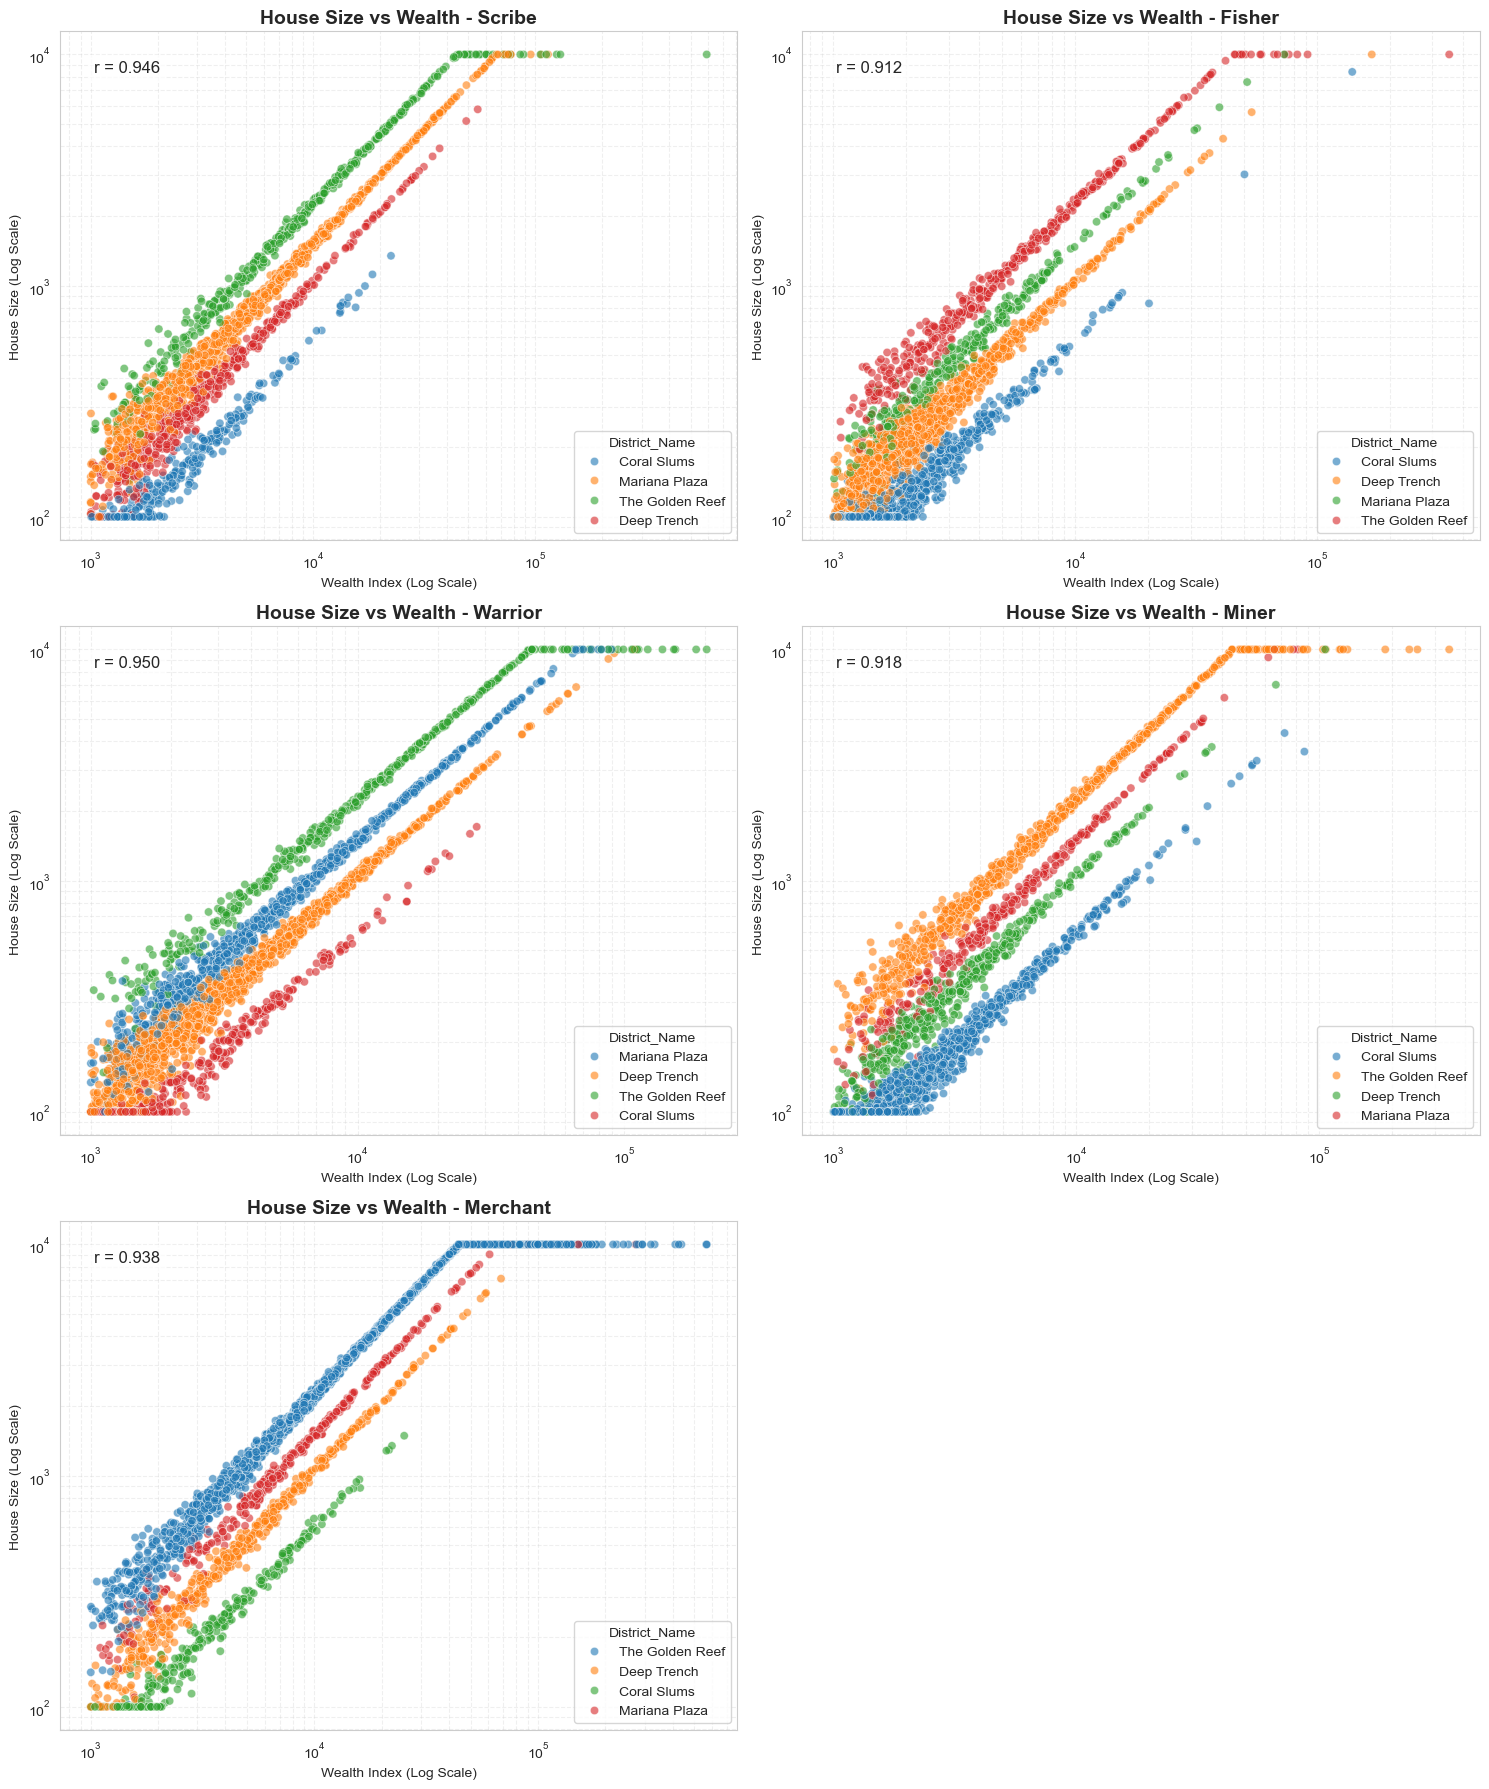

In [21]:

from scipy.stats import pearsonr
import math

occupations = train['Occupation'].unique()
num_plots = len(occupations)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols) # Automatically sets rows based on count

plt.figure(figsize=(15, 6 * num_rows))

for i, occ in enumerate(occupations, 1):
    plt.subplot(num_rows, num_cols, i)
    
    # Filter non-positive values
    subset = train[(train['Occupation'] == occ) & 
                   (train['Wealth_Index'] > 0) & 
                   (train['House_Size_sq_ft'] > 0)].copy()
    
    if len(subset) > 1:
        # Correlation calculation
        log_wealth = np.log10(subset['Wealth_Index'])
        log_house = np.log10(subset['House_Size_sq_ft'])
        corr, _ = pearsonr(log_wealth, log_house)
        
        # Plotting
        sns.scatterplot(
            data=subset,
            x='Wealth_Index',
            y='House_Size_sq_ft',
            hue='District_Name',
            alpha=0.6,
            color='teal'
        )
        
        # Log Scales
        plt.xscale('log')
        plt.yscale('log')
        
        # Labels and Style
        plt.title(f'House Size vs Wealth - {occ}', fontsize=14, fontweight='bold')
        plt.xlabel('Wealth Index (Log Scale)')
        plt.ylabel('House Size (Log Scale)')
        
        # Annotate Correlation
        plt.text(0.05, 0.92, f'r = {corr:.3f}', 
                 transform=plt.gca().transAxes, 
                 fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.7))
        
        plt.grid(True, which="both", linestyle='--', alpha=0.3)
    else:
        plt.text(0.5, 0.5, f'Insufficient data for {occ}', ha='center')

plt.tight_layout()
plt.show()

DROPPING ROWS WHERE BOTH WEALTH_INDEX AND HOUSE SIZE ARE ABSENT

In [22]:
# Drop rows where both Wealth_Index, House_Size_sq_ft are null
train = train.dropna(
    subset=['Wealth_Index', 'House_Size_sq_ft'],
    how='all'
)

# Checking how many rows remain
print("Remaining rows:", train.shape[0])


Remaining rows: 15669


REVIEWING HOW MANY MISSING ROWS IN LIFE_EXPECTANCY COLUMN

In [23]:
missing_count = train['Life_Expectancy'].isnull().sum()
print(f"Missing values in Life_Expectancy: {missing_count}")

Missing values in Life_Expectancy: 611


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15669 entries, 0 to 15750
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Citizen_ID        15669 non-null  object 
 1   Diet_Type         15669 non-null  object 
 2   District_Name     15669 non-null  object 
 3   Occupation        15669 non-null  object 
 4   Wealth_Index      15669 non-null  float64
 5   House_Size_sq_ft  15669 non-null  float64
 6   Life_Expectancy   15058 non-null  float64
 7   Vehicle_Owned     15669 non-null  object 
 8   Work_District     15669 non-null  object 
 9   Bio_Hash          15669 non-null  object 
dtypes: float64(3), object(7)
memory usage: 1.3+ MB


**(12)**

    CALCULATING MEDIAN LIFE EXPECTANCY OCCUPATION-WISE

In [25]:

occ_life_median = train.groupby('Occupation')['Life_Expectancy'].median().sort_values(ascending=False).reset_index()

occ_life_median.columns = ['Occupation', 'Median_Life_Expectancy']

print("--- Occupation-wise Median Life Expectancy ---")
print(occ_life_median)

--- Occupation-wise Median Life Expectancy ---
  Occupation  Median_Life_Expectancy
0   Merchant                    65.0
1     Scribe                    58.0
2      Miner                    46.0
3     Fisher                    43.0
4    Warrior                    39.0


**(13)** 

    CALCULATING MEAN WEALTH DISTRICT WISE

In [26]:

district_life_mean = train.groupby('Work_District')['Wealth_Index'].mean().sort_values(ascending=False).reset_index()

district_life_mean.columns = ['Work_District', 'Mean_Wealth_Index']

print("--- District-wise Mean Wealth ---")
print(district_life_mean)

--- District-wise Mean Wealth ---
     Work_District  Mean_Wealth_Index
0    Mariana Plaza       11487.336998
1  The Golden Reef       11449.891291
2      Coral Slums        7559.508370
3      Deep Trench        7490.393717


**(14)**

    ANALYSING DISTRIBUTION OF MISSING ROWS IN LIFE EXPECTANCY COLUMN

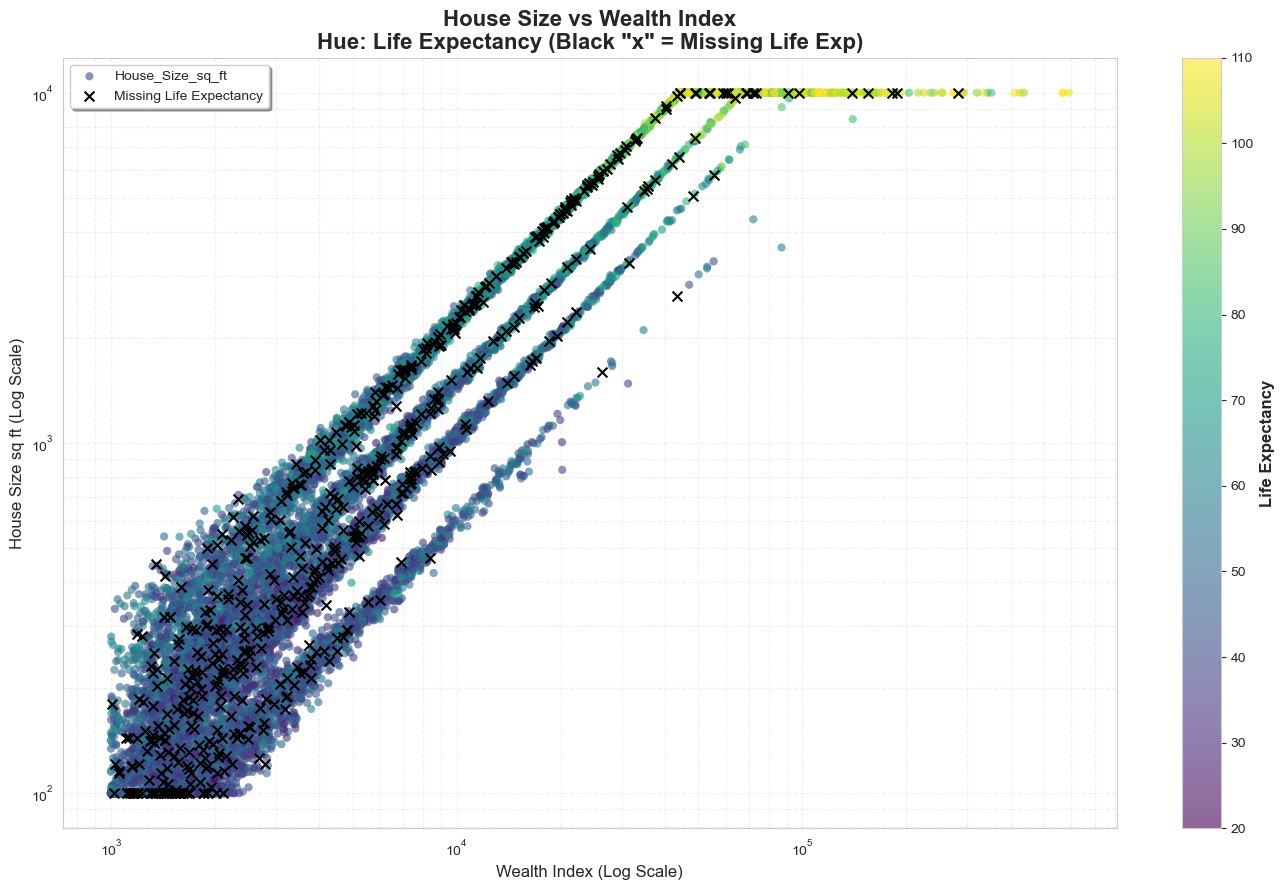

In [27]:
# below is juat a precaution, not compulsory though.
# Filtering rows where both Wealth and House Size are known
# (Excluding rows where these are 0 or NaN to allow for Log Scaling)
valid_xy = train[(train['Wealth_Index'] > 0) & (train['House_Size_sq_ft'] > 0)].copy()

# Separate into groups based on Life_Expectancy
known_life = valid_xy[valid_xy['Life_Expectancy'].notna()]
missing_life = valid_xy[valid_xy['Life_Expectancy'].isna()]

plt.figure(figsize=(14, 9))

# Plot points with Known Life Expectancy (Continuous Color Gradient)
sc = plt.scatter(
    data=known_life, 
    x='Wealth_Index', 
    y='House_Size_sq_ft', 
    c='Life_Expectancy', 
    cmap='viridis', 
    alpha=0.6, 
    s=35,
    edgecolors='none'
)

# Adding the colorbar to show the Life Expectancy scale
cbar = plt.colorbar(sc)
cbar.set_label('Life Expectancy', fontsize=12, fontweight='bold')

# Mark points with Missing Life Expectancy in black X
plt.scatter(
    data=missing_life, 
    x='Wealth_Index', 
    y='House_Size_sq_ft', 
    color='black', 
    alpha=1.0, 
    s=50, 
    marker='x', 
    label='Missing Life Expectancy'
)

plt.xscale('log')
plt.yscale('log')

plt.title('House Size vs Wealth Index\nHue: Life Expectancy (Black "x" = Missing Life Exp)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Wealth Index (Log Scale)', fontsize=12)
plt.ylabel('House Size sq ft (Log Scale)', fontsize=12)

# Adding a legend for the black markers
plt.legend(loc='upper left', frameon=True, shadow=True)

plt.grid(True, which="both", linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**(15)**

    LIFE EXPECTANCY VS Log(HOUSE SIZE), HUE = OCCUPATTION

<Figure size 1200x800 with 0 Axes>

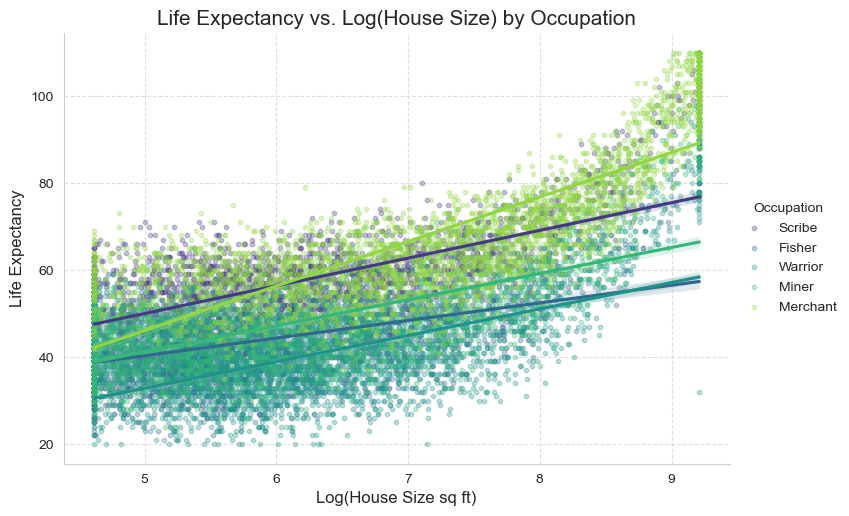

In [28]:

plot_df = train.copy()

plot_df['log_House_Size'] = np.log1p(plot_df['House_Size_sq_ft'])

plt.figure(figsize=(12, 8))

sns.lmplot(
    data=plot_df, 
    x='log_House_Size', 
    y='Life_Expectancy', 
    hue='Occupation', 
    palette='viridis',
    scatter_kws={'alpha': 0.3, 's': 10}, # Make dots small and transparent to see density
    aspect=1.5
)

plt.title('Life Expectancy vs. Log(House Size) by Occupation', fontsize=15)
plt.xlabel('Log(House Size sq ft)', fontsize=12)
plt.ylabel('Life Expectancy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [29]:

train['log_House_Size'] = np.log1p(train['House_Size_sq_ft'])

# Calculate correlation per occupation
results = []
for occ in train['Occupation'].unique():
    # Filter for the occupation and drop NaNs in the relevant columns
    subset = train[train['Occupation'] == occ][['log_House_Size', 'Life_Expectancy']].dropna()
    
    if len(subset) > 1:
        corr = subset['log_House_Size'].corr(subset['Life_Expectancy'])
        results.append({
            'Occupation': occ,
            'Correlation': round(corr, 4),
            'Sample_Size': len(subset)
        })

# Create a table and display it
corr_table = pd.DataFrame(results).sort_values(by='Correlation', ascending=False)

print("--- Correlation: log(House_Size) vs Life_Expectancy ---")
print(corr_table.to_string(index=False))

train = train.drop('log_House_Size', axis=1)

--- Correlation: log(House_Size) vs Life_Expectancy ---
Occupation  Correlation  Sample_Size
  Merchant       0.7918         3359
     Miner       0.6578         2885
    Scribe       0.6555         2407
   Warrior       0.6321         3389
    Fisher       0.4613         3018


OBSERVATION: 

    Merchant has highest correlation in Log(House Size) vs Life Expectancy whereas Fisher has the lowest.

**(16)**

   ANALYSING DEPENDENCIES OF LIFE EXPECTANCY ON VARIOUS OTHER COLUMNS. 
   JUST TAKING AN IDEA, IT WILL CHANGE AFTER FEATURE ENGINEERING.

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

features_df = train.drop(columns=['Citizen_ID', 'Bio_Hash'], errors='ignore').dropna(subset=['Life_Expectancy'])
target = features_df['Life_Expectancy']
features = features_df.drop(columns=['Life_Expectancy'])

# Linear Correlation (Numerical only)
print("--- Linear Correlation with Life Expectancy ---")
correlations = features.select_dtypes(include=[np.number]).corrwith(target).abs().sort_values(ascending=False)
print(correlations)

# Mutual Information (Captures Non-linear & Categorical dependencies)
def calculate_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    
    # All categorical features to integers
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

print("\n--- Mutual Information Scores (Overall Dependency) ---")
mi_rank = calculate_mi_scores(features, target)
print(mi_rank)

--- Linear Correlation with Life Expectancy ---
House_Size_sq_ft    0.797883
Wealth_Index        0.587822
dtype: float64

--- Mutual Information Scores (Overall Dependency) ---
House_Size_sq_ft    0.417602
Occupation          0.399360
Wealth_Index        0.346466
District_Name       0.191290
Work_District       0.088748
Diet_Type           0.074060
Vehicle_Owned       0.049354
Name: MI Scores, dtype: float64


FLAGGING THE ROWS WHERE LIFE EXPECTANCY COLUMN WAS MISSING (TO IMPROVE OUR MODEL PERFORMANCE)

In [31]:
train['Life_Exp_Was_Missing'] = train['Life_Expectancy'].isna().astype(int)
test['Life_Exp_Was_Missing'] = test['Life_Expectancy'].isna().astype(int)

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15669 entries, 0 to 15750
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Citizen_ID            15669 non-null  object 
 1   Diet_Type             15669 non-null  object 
 2   District_Name         15669 non-null  object 
 3   Occupation            15669 non-null  object 
 4   Wealth_Index          15669 non-null  float64
 5   House_Size_sq_ft      15669 non-null  float64
 6   Life_Expectancy       15058 non-null  float64
 7   Vehicle_Owned         15669 non-null  object 
 8   Work_District         15669 non-null  object 
 9   Bio_Hash              15669 non-null  object 
 10  Life_Exp_Was_Missing  15669 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 1.4+ MB


**(17)**

    CHECKING IF THERE IS ANY PATTERN IN RESIDING DTSRICT AND WORKING DISTRICT

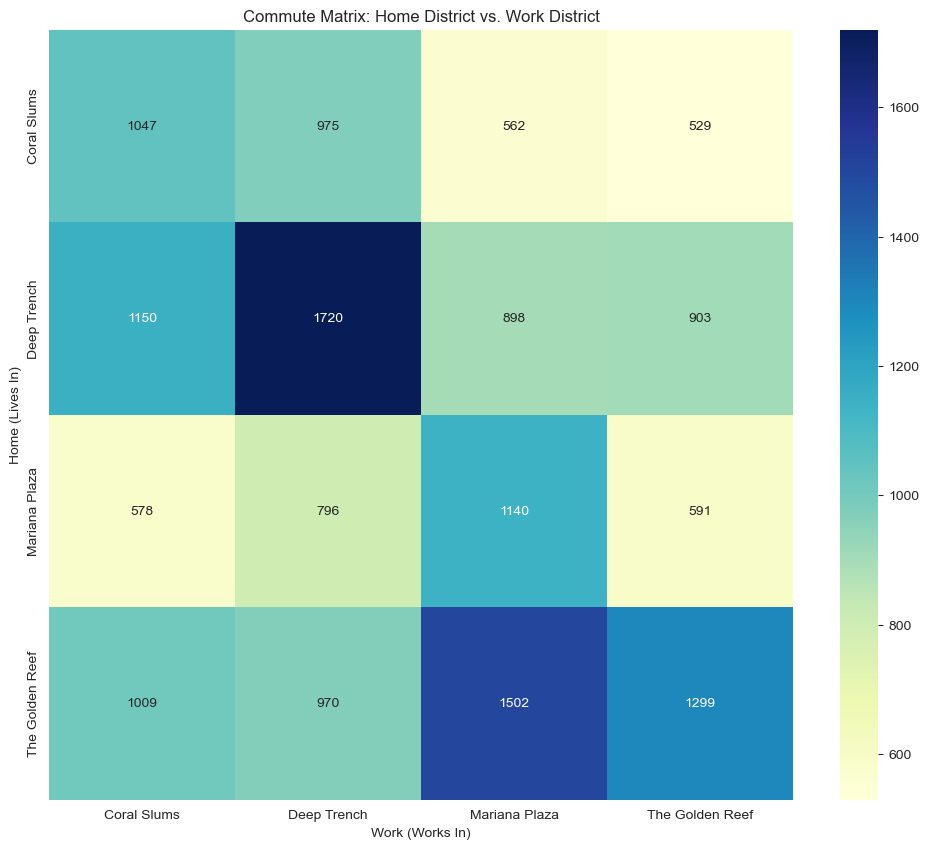

In [33]:
# Create a pivot table of counts
commute_matrix = pd.crosstab(train['District_Name'], train['Work_District'])

plt.figure(figsize=(12, 10))
sns.heatmap(commute_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Commute Matrix: Home District vs. Work District')
plt.ylabel('Home (Lives In)')
plt.xlabel('Work (Works In)')
plt.show()

OBSERVATION: 

    Helps to create a feature 'Is_Local_Worker' to improve our model performance.

FILLING MISSING VALUES IN LIFE EXPECTANCY WITH HELP OF THEIR ALMOST IDENTICAL TWINS.

In [34]:

missing_df = train[train['Life_Expectancy'].isna()].copy().reset_index()
known_df = train[train['Life_Expectancy'].notna()].copy().reset_index()

categorical_cols = ['Diet_Type', 'District_Name', 'Occupation', 'Vehicle_Owned', 'Work_District']
numerical_cols = ['Wealth_Index', 'House_Size_sq_ft']

# Comparing on Categorical columns
matches = missing_df.merge(
    known_df, 
    on=categorical_cols, 
    suffixes=('_miss', '_known')
)

# Filter on 3% numerical range
for col in numerical_cols:
    matches = matches[
        (np.abs(matches[f'{col}_miss'] - matches[f'{col}_known']) / (matches[f'{col}_known'] + 1e-6)) <= 0.03
    ]

# Collapse with Median for both Target and Numerical Features
unique_matches = matches.groupby('index_miss').agg({
    'Occupation': 'first',
    'District_Name': 'first',
    'Wealth_Index_miss': 'first',
    'Wealth_Index_known': 'median',       # Median wealth of the twins
    'House_Size_sq_ft_miss': 'first',
    'House_Size_sq_ft_known': 'median',   # Median house size of the twins
    'Life_Expectancy_known': 'median',    # Target median
    'index_known': 'count'                # Count of twins found
}).reset_index()

unique_matches.columns = [
    'Row_ID', 'Occ', 'District', 
    'Wealth_Miss', 'Wealth_Twin_Med', 
    'House_Miss', 'House_Twin_Med', 
    'Life_Exp_To_Fill', 'Twins_Count'
]

print(f"Total Missing Rows: {len(missing_df)}")
print(f"Successfully Matched: {len(unique_matches)}")

if not unique_matches.empty:
    print("\n--- Detailed View: Missing Values vs. Twin Medians ---")
    # Displaying top matches, sorted by Twins_Count to see the median logic in action
    display(unique_matches.sort_values(by='Twins_Count', ascending=False).head(10))

Total Missing Rows: 611
Successfully Matched: 121

--- Detailed View: Missing Values vs. Twin Medians ---


Row_ID       Occ         District   Wealth_Miss  Wealth_Twin_Med  \
50     6731    Fisher      Coral Slums   1133.000000      1146.000000   
13     1767  Merchant  The Golden Reef  23857.000000     23554.000000   
59     7531    Fisher      Coral Slums   1341.000000      1361.000000   
104   13419  Merchant  The Golden Reef  21910.000000     21760.000000   
35     5169     Miner      Coral Slums   1446.559468      1453.000000   
54     7140  Merchant  The Golden Reef  21408.000000     21537.500000   
83    10288  Merchant  The Golden Reef  29734.000000     29149.842058   
60     7652  Merchant  The Golden Reef  19827.000000     19699.000000   
69     8285     Miner      Coral Slums   1471.000000      1473.109741   
3       474  Merchant  The Golden Reef  15511.000000     15458.000000   

      House_Miss  House_Twin_Med  Life_Exp_To_Fill  Twins_Count  
50    100.000000           100.0              45.0            7  
13   5389.000000          5331.0              76.0            5  
59    100.000000           100.0              45.0            5  
104  4934.180206          4945.0              71.0            5  
35    100.000000           100.0              41.5            4  
54   4938.000000          4849.5              84.0            4  
83   6712.399109          6630.0              81.0            4  
60   4426.000000          4393.0              78.5            4  
69    100.000000           100.0              37.5            4  
3    3483.555070          3452.0              73.0            4

In [35]:
# Create a clean Map (Original Index -> Calculated Median)
# unique_matches['Row_ID'] contains the original index from train
impute_map = unique_matches.set_index('Row_ID')['Life_Exp_To_Fill']

# Applying the values only to the missing cells
# fillna(impute_map) looks at the index and matches the value perfectly
train['Life_Expectancy'] = train['Life_Expectancy'].fillna(impute_map)

remaining_missing = train['Life_Expectancy'].isna().sum()
rows_filled = len(unique_matches)

print(f"Rows successfully updated: {rows_filled}")
print(f"Missing cells left in 'Life_Expectancy': {remaining_missing}")

print("\nFirst 5 updated values:")
print(train.loc[impute_map.index[:5], ['Occupation', 'Life_Expectancy']])

Rows successfully updated: 121
Missing cells left in 'Life_Expectancy': 490

First 5 updated values:
       Occupation  Life_Expectancy
Row_ID                            
295         Miner             49.0
300       Warrior             33.0
392       Warrior             42.0
474      Merchant             73.0
545        Scribe             75.0


AGAIN REVIEWING THE LIFE EXPECTANCY COLUMN

In [36]:
missing_count = train['Life_Expectancy'].isnull().sum()
print(f"Missing values in Life_Expectancy: {missing_count}")

Missing values in Life_Expectancy: 490


**(18)**

    CALCULATING MEDIAN LIFE EXPECTANCY OCCUPATION WISE

In [37]:
# Calculate the median life expectancy for each occupation
occ_life_median = train.groupby('Occupation')['Life_Expectancy'].median().sort_values(ascending=False).reset_index()

occ_life_median.columns = ['Occupation', 'Median_Life_Expectancy']

print("--- Occupation-wise Median Life Expectancy ---")
print(occ_life_median)

--- Occupation-wise Median Life Expectancy ---
  Occupation  Median_Life_Expectancy
0   Merchant                    66.0
1     Scribe                    58.0
2      Miner                    46.0
3     Fisher                    43.0
4    Warrior                    39.0


**(19)**

    ANALYSNG LIFE STATUS OF PEOPLE WITH ROYAL SUBMARINE AS THEIR VEHICLE

In [38]:

submarines = train[train['Vehicle_Owned'] == 'Royal Submarine']

mean_le = submarines['Life_Expectancy'].mean()
mean_wi = submarines['Wealth_Index'].mean()
median_wi = submarines['Wealth_Index'].median()
mean_hs = submarines['House_Size_sq_ft'].mean()
median_hs = submarines['House_Size_sq_ft'].median()
median_le = submarines['Life_Expectancy'].median()
count = submarines['Life_Expectancy'].count()
missing = submarines['Life_Expectancy'].isna().sum()

print(f"--- 'Royal Submarine' Life Expectancy Stats ---")
print(f"Total Rows: {len(submarines)}")
print(f"Rows with Data: {count}")
print(f"Rows Missing Data: {missing}")
print(f"Mean Life Expectancy: {mean_le:.2f}")
print(f"Median Life Expectancy: {median_le:.2f}")
print(f"Mean Wealth_Index: {mean_wi:.2f}")
print(f"Median Wealth_Index: {median_wi:.2f}")
print(f"Mean House_Size_sq_ft: {mean_hs:.2f}")
print(f"Median House_Size_sq_ft: {median_hs:.2f}")

# most common occupation for submarine owners
if not submarines.empty:
    common_occ = submarines['Occupation'].mode()[0]
    print(f"Most Common Occupation: {common_occ}")

--- 'Royal Submarine' Life Expectancy Stats ---
Total Rows: 118
Rows with Data: 113
Rows Missing Data: 5
Mean Life Expectancy: 100.30
Median Life Expectancy: 103.00
Mean Wealth_Index: 162181.20
Median Wealth_Index: 126953.00
Mean House_Size_sq_ft: 9985.64
Median House_Size_sq_ft: 10000.00
Most Common Occupation: Merchant


OBSERVATION: 

    People with Royal Submarine are living high standard life with genrally high life expectancy as well as high wealth, large houses etc.
    Most of them are Merchants.

FILLING THE REST MISSING VALUES IN LIFE EXPECTANCY USING THE BELOW SCHEME

In [39]:

def fill_train_final_logic(df):
    # Calculating occupation-specific global medians for the final step if there are any rows left
    occ_medians = df.groupby('Occupation')['Life_Expectancy'].median()
    
    missing_idx = df[df['Life_Expectancy'].isna()].index
    filled_values = {}
    
    for idx in missing_idx:
        current_house_size = df.loc[idx, 'House_Size_sq_ft']
        current_occ = df.loc[idx, 'Occupation']
        
        # Defining the 5% window based on House_Size_sq_ft
        lower_bound = current_house_size * 0.97
        upper_bound = current_house_size * 1.03
        
        # Same Occupation AND House Size within 3%
        matches = df[
            (df['Occupation'] == current_occ) & 
            (df['House_Size_sq_ft'] >= lower_bound) & 
            (df['House_Size_sq_ft'] <= upper_bound) &
            (df['Life_Expectancy'].notna())
        ]
        
        if not matches.empty:
            # Fill with median of the occupation-specific window (i.e. in twins)
            filled_values[idx] = matches['Life_Expectancy'].median()
        else:
            # 3. If no match in window, fill with the Global Median for that Occupation
            filled_values[idx] = occ_medians[current_occ]
            
    return pd.Series(filled_values)

train_fills = fill_train_final_logic(train)
train['Life_Expectancy'] = train['Life_Expectancy'].fillna(train_fills)

FEATURE ENGINEERING

In [40]:

for df in [train, test]:
    df['Wealth_Index'] = np.log1p(df['Wealth_Index'])
    df['House_Size_sq_ft'] = np.log1p(df['House_Size_sq_ft'])
    # New Interaction Feature
    df['Wealth_per_SqFt'] = df['Wealth_Index'] / (df['House_Size_sq_ft'])
    df['Wealth_per_age'] = df['Wealth_Index'] / (df['Life_Expectancy'])
    # Returns 1 if they match, 0 if they don't
    df['Is_Local_Worker'] = (df['District_Name'] == df['Work_District']).astype(int)

PREPARING TRAIN AND TEST DATASET FOR TRAINING

In [41]:


X = train.drop(columns=['Occupation', 'Citizen_ID', 'Bio_Hash'], errors='ignore')
y = train['Occupation'] 
X_test = test.drop(columns=['Citizen_ID', 'Bio_Hash'], errors='ignore')
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

string_to_num = {'Warrior': 0, 'Merchant': 1, 'Fisher': 2, 'Miner': 3, 'Scribe': 4}


TRAINING OUR CATBOOST MODEL (catboost is excellent for datasets involving tabular data with heavy categorical features)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15669 entries, 0 to 15750
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diet_Type             15669 non-null  object 
 1   District_Name         15669 non-null  object 
 2   Wealth_Index          15669 non-null  float64
 3   House_Size_sq_ft      15669 non-null  float64
 4   Life_Expectancy       15669 non-null  float64
 5   Vehicle_Owned         15669 non-null  object 
 6   Work_District         15669 non-null  object 
 7   Life_Exp_Was_Missing  15669 non-null  int64  
 8   Wealth_per_SqFt       15669 non-null  float64
 9   Wealth_per_age        15669 non-null  float64
 10  Is_Local_Worker       15669 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 1.9+ MB


In [43]:

# Seed Averaging
all_test_probs = []
all_train_probs = [] # To calculate local F1
seeds = [42, 123, 789, 2024, 555]

for seed in seeds:
    model = CatBoostClassifier(
        iterations=2000,
        learning_rate=0.03,
        depth=6,
        loss_function='MultiClass',
        eval_metric='TotalF1',
        random_seed=seed,
        verbose=0,
        auto_class_weights='Balanced',
    )
    
    model.fit(X, y, cat_features=cat_features)
    
    # Storing probabilities for Test (Leaderboard) and Train (Local F1)
    all_test_probs.append(model.predict_proba(X_test))
    all_train_probs.append(model.predict_proba(X))
    print(f"Seed {seed} completed.")

Seed 42 completed.
Seed 123 completed.
Seed 789 completed.
Seed 2024 completed.
Seed 555 completed.


CALCULATING LOCAL F1 SCORES JUST TO GET AN IDEA WHETHER OUR MODEL IS IMPROVING OR NOT

In [44]:
from sklearn.metrics import f1_score
# Calculate Local F1
# Average the probabilities across all seeds for the training data
avg_train_probs = np.mean(all_train_probs, axis=0)
train_preds_indices = np.argmax(avg_train_probs, axis=1)

# Map everything to numbers to calculate the score
class_map = model.classes_ 
y_true_num = [string_to_num[str(label)] for label in y]
train_preds_num = [string_to_num[str(class_map[i])] for i in train_preds_indices]

final_f1 = f1_score(y_true_num, train_preds_num, average='weighted')

print(f" ENSEMBLE LOCAL F1 SCORE: {final_f1:.4f}")


 ENSEMBLE LOCAL F1 SCORE: 0.6934


CREATING FILE FOR SUBMISSION

In [45]:

avg_test_probs = np.mean(all_test_probs, axis=0)
test_preds_indices = np.argmax(avg_test_probs, axis=1)

final_occupation_labels = [class_map[i] for i in test_preds_indices]
final_numeric_preds = [string_to_num[label] for label in final_occupation_labels]

submission = pd.DataFrame({
    'Citizen_ID': test['Citizen_ID'],
    'Occupation': final_numeric_preds
})

submission.to_csv('submission.csv', index=False)
print(" submission.csv created.")

 submission.csv created.


PRINTING FEATURE IMPORTANCE OF VARIOUS COLUMNS TO SEE WHERE OUR MODEL CAN IMPROVE

In [46]:


feature_importances = model.get_feature_importance(type='FeatureImportance')
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("--- Feature Importance Ranking ---")
print(importance_df)

--- Feature Importance Ranking ---
                 Feature  Importance
9         Wealth_per_age   25.685365
4        Life_Expectancy   15.675713
6          Work_District   14.609864
1          District_Name   12.130948
0              Diet_Type    8.467579
2           Wealth_Index    6.650378
3       House_Size_sq_ft    6.271244
5          Vehicle_Owned    4.719175
8        Wealth_per_SqFt    4.501670
7   Life_Exp_Was_Missing    0.765571
10       Is_Local_Worker    0.522493
